# PRL paper: https://journals-aps-org.libaccess.sjlibrary.org/prl/pdf/10.1103/PhysRevLett.126.213601

# Supplemental Material: https://journals-aps-org.libaccess.sjlibrary.org/prl/supplemental/10.1103/PhysRevLett.126.213601/SiVcompare_SM8edits2.pdf

# article of nice plots: https://towardsdatascience.com/how-to-create-and-use-custom-matplotlib-style-sheet-9393f498063

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.integrate as spint
import cmath
# plt.style.use('seaborn-pastel')
plt.rcParams['font.family'] = 'sans-serif'
COLOR = 'w'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.edgecolor'] = 'k'
SIZE = 8
plt.rcParams['font.size'] = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['figure.titlesize'] = SIZE
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 800
# plt.rcParams['image.cmap'] = 'coolwarm'
plt.rcParams['image.cmap'] = 'viridis'

res = 200
MC_N = int(1e3)
peakVals = 1
MC_all = 1

# rcParams parameters https://matplotlib.org/stable/users/dflt_style_changes.html

# parameters

Delta_ZPL_0 = 0.  # 406 THz  Meesala
lambda_SO_gs = 0.1  # 46 GHz  Meesala
lambda_SO_es = 0.5  # 255 GHz  Meesala

t_para = -1.  # -1.7 PHz/strain  Meesala
t_perp = 0.1  # 0.078 PHz/strain   Meesala
d_gs = 1.  # 1.3 PHz/strain   Meesala
d_es = 1.  # 1.8 PHz/strain   Meesala
f_gs = -1.  # -1.7 PHz/strain   Meesala
f_es = -1. # -3.4 PHz/strain   Meesala

sigma = 4.  # 1.84 +- 0.02 THz
# gamma_10 = sigma * 1e-3  # 1.33 +- 0.06 GHz
gamma_10 = 0.05 # 28 GHz  Smallwood PRL

poi = -0.2 # Poisson ratio of diamond, Kelsey

omega_t = np.linspace(-1., 1., res) * 4.
omega_tau = np.linspace(-1., 1., res)  * 4.

In [88]:
Delta_ZPL_0 = 406.83 * 0.  # 406 THz  Meesala
lambda_SO_gs = 46e-3  # 46 GHz  Meesala
lambda_SO_es = 255e-3  # 255 GHz  Meesala

t_para = -1.7e3  # -1.7 PHz/strain  Meesala
t_perp = 0.078e3  # 0.078 PHz/strain   Meesala
d_gs = 1.3e3  # 1.3 PHz/strain   Meesala
d_es = 1.8e3  # 1.8 PHz/strain   Meesala
f_gs = -1.7e3  # -1.7 PHz/strain   Meesala
f_es = -3.4e3 # -3.4 PHz/strain   Meesala

sigma = 1e-4 # Kelsey
gamma_10 = 1.33e-3  # 28 GHz p.3 or 1.33 Ghz p.5 Smallwood PRL
# gamma_10 = 1e-4 # fwhm = 10e-3 Kelsey

poi = -0.2  # Poisson ratio of diamond, Kelsey

# omega_t = np.linspace(402.25, 409.5, res)
# omega_tau = np.linspace(-409.5, -402.25, res)

omega_t = np.linspace(405.5, 408.75, res)
omega_tau = np.linspace(-408.75, -405.5, res)

# omega_t = np.linspace(-0.5, 0.5, res)
# omega_tau = np.linspace(-0.5, 0.5, res)

# colorbar function

In [89]:
# @numba.jit
def colorbar(mappable, label='arb. units'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if label is not None:
        plt.ylabel(label)
    plt.sca(last_axes)
    return cbar

# creating mesh

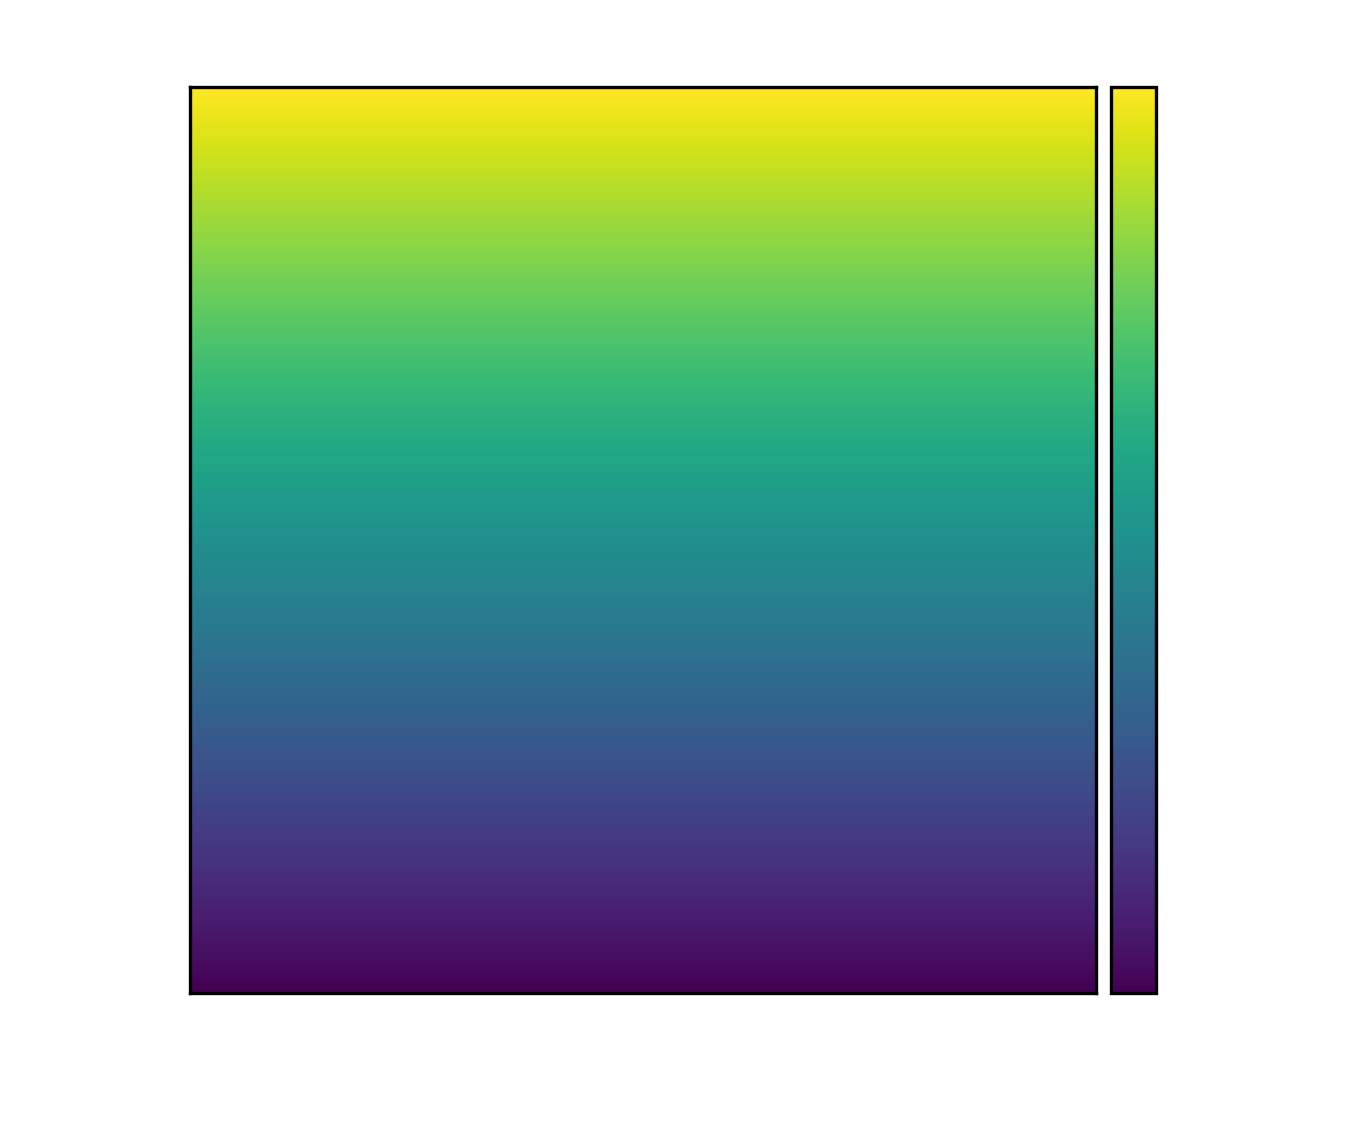

In [90]:
omega_t_mesh, omega_tau_mesh = np.meshgrid(omega_t, omega_tau, indexing='xy')
plt.figure()
im = plt.imshow(omega_tau_mesh, 
                origin='lower', 
                extent=(min(omega_t), 
                        max(omega_t), 
                        min(omega_tau), 
                        max(omega_tau)))
plt.xlabel(r'$\omega_t$')
plt.ylabel(r'$\omega_\tau$')
plt.title(r'$\omega_\tau$ mesh')
colorbar(im)
plt.show()

# multiple plot function

In [91]:
# @numba.jit
def slices_plots(
    databox,
    titles=None,
    figure_shape=[4, 4],
    figure_size=(11, 10),
    vertical_gap=0.15,
    horizontal_gap=0.15,
    shared_x_label=r'$\omega_t \quad$',
    shared_x_label_x_position=0.515,
    shared_x_label_y_position=0.09,
    shared_y_label=r'$\omega_\tau \quad$',
    shared_y_label_x_position=0.08,
    shared_y_label_y_position=0.5,
    shared_title=r'$\mathfrak{R} \left\{ \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau) \right\}$',
    shared_title_x_position=0.515,
    shared_title_y_position=0.93,
    share_x_axis=True,
    share_y_axis=True,
    colorbar_labels='arb. units',
    EXTENT=(min(omega_t), max(omega_t), min(omega_tau), max(omega_tau))):

    fig, ax = plt.subplots(
        figure_shape[0],  # row
        figure_shape[1],  # column
        figsize=figure_size,
        sharex=share_x_axis,
        sharey=share_y_axis,
        gridspec_kw={
            "hspace": vertical_gap,
            'wspace': horizontal_gap
        })

    for i in range(np.shape(databox)[0]):
        im = ax.flatten()[i].imshow(databox[i],
                                    origin='lower',
                                    extent=EXTENT)
        ax.flatten()[i].set_title(titles[i])

        if np.size(colorbar_labels) == 1:
            if (i + 1) % figure_shape[1]:
                colorbar(im, None)
            else:
                colorbar(im, colorbar_labels)
        else:
            colorbar(im, colorbar_labels[i])

    fig.suptitle(x=shared_title_x_position,
                 y=shared_title_y_position,
                 t=shared_title,
                 ha='center',
                 size=1.5 * SIZE)

    if shared_x_label != None:  # shared x label
        fig.text(x=shared_x_label_x_position,
                 y=shared_x_label_y_position,
                 s=shared_x_label,
                 ha='center')

    if shared_y_label != None:  # shared y label
        fig.text(x=shared_y_label_x_position,
                 y=shared_y_label_y_position,
                 s=shared_y_label,
                 va='center',
                 rotation='vertical')

    plt.show()
    return fig

# complex square function

In [92]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def abs2(x):

    return x.real**2. + x.imag**2.

# complex phase

In [93]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def phase(x):

    return cmath.phase(x)

\begin{equation}\label{eq:1}
    \Delta_{ZPL}(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}) = \Delta_{ZPL,0} + (t_{\parallel,es} - t_{\parallel,gs})\epsilon_{zz} + (t_{\perp,es} - t_{\perp,gs})(\epsilon_{xx} + \epsilon_{yy})
\end{equation}


In [94]:
@numba.jit
def Delta_ZPL(eps_xx=0., 
              eps_yy=0., 
              eps_zz=0.):
    
    return Delta_ZPL_0 + t_para*eps_zz + t_perp*(eps_xx + eps_yy)

\begin{equation}\label{eq:2}
    \Delta_{gs}(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = \sqrt{\lambda_{SO,gs}^2 + 4[d_{gs}(\epsilon_{xx} - \epsilon_{yy}) + f_{gs} \epsilon_{yz}]^2 + 4[-2d_{gs} \epsilon_{xy} + f_{gs} \epsilon_{zx}]^2}
\end{equation}

In [95]:
@numba.jit
def Delta_gs(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_gs**2.,
            4. * (d_gs * (eps_xx - eps_yy) + f_gs * eps_yz)**2.,
            4. * (-2. * d_gs * eps_xy + f_gs * eps_zx)**2.
        ]))

\begin{equation}\label{eq:3}
    \Delta_{es}(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = \sqrt{\lambda_{SO,es}^2 + 4[d_{es}(\epsilon_{xx} - \epsilon_{yy}) + f_{es} \epsilon_{yz}]^2 + 4[-2d_{es} \epsilon_{xy} + f_{es} \epsilon_{zx}]^2}
\end{equation}

In [96]:
@numba.jit
def Delta_es(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_es**2.,
            4. * (d_es * (eps_xx - eps_yy) + f_es * eps_yz)**2.,
            4. * (-2. * d_es * eps_xy + f_es * eps_zx)**2.
        ]))

\begin{equation}\label{eq:4}
    \rho (\omega_t, \omega_{\tau}, \epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = \left( \frac{i \sqrt{A} \, \gamma_{10}}{\omega_t-[\Delta_{ZPL} \pm \Delta_{gs} \pm \Delta_{es} - i \gamma_{10}]} \right ) \left (\frac{i \sqrt{A} \, \gamma_{10}}{\omega_{\tau}+[\Delta_{ZPL} \pm \Delta_{gs} \pm \Delta_{es} + i \gamma_{10}]} \right)
\end{equation}


In [97]:
@numba.jit
def rho(omega_t,
        omega_tau,
        eps_xx=0.,
        eps_yy=0.,
        eps_zz=0.,
        eps_yz=0.,
        eps_xy=0.,
        eps_zx=0.):

    Del_ZPL = Delta_ZPL(eps_xx, eps_yy, eps_zz)

    Del_gs = Delta_gs(eps_xx, eps_yy, eps_yz, eps_xy, eps_zx)

    Del_es = Delta_es(eps_xx, eps_yy, eps_yz, eps_xy, eps_zx)

#     amp = np.array(
#         [1., 1., 1., 1., 
#          1., 1., 1., 1., 
#          1., 1., 1., 1., 
#          1., 1., 1., 1.])
    
    amp = np.array(
        [0.0938, 0.0833, 0.0579, 0.0576,
         0.0709, 1.0000, 0.0799, 0.1521, 
         0.0631, 0.0837, 0.3036, 0.0737, 
         0.0522, 0.1212, 0.0581, 0.1228])

    sign = np.array([[ 1.,  1.,  1.,  1.], 
                     [ 1.,  1.,  1., -1.], 
                     [ 1.,  1., -1.,  1.],
                     [ 1.,  1., -1., -1.], 
                     [ 1., -1.,  1.,  1.], 
                     [ 1., -1.,  1., -1.],
                     [ 1., -1., -1.,  1.], 
                     [ 1., -1., -1., -1.],
                     [-1.,  1.,  1.,  1.], 
                     [-1.,  1.,  1., -1.], 
                     [-1.,  1., -1.,  1.],
                     [-1.,  1., -1., -1.], 
                     [-1., -1.,  1.,  1.],
                     [-1., -1.,  1., -1.], 
                     [-1., -1., -1.,  1.],
                     [-1., -1., -1., -1.]])

    RHO = 1.j * np.zeros(np.shape(omega_t))

    for i in range(np.shape(sign)[0]):
        t_Lorentz = 1.j * np.sqrt(amp[i]) * gamma_10 / (
            omega_t - (Del_ZPL + sign[i, 0] * Del_gs + sign[i, 1] * Del_es -
                       1.j * gamma_10))
        tau_Lorentz = 1.j * np.sqrt(amp[i]) * gamma_10 / (
            omega_tau + (Del_ZPL + sign[i, 2] * Del_gs + sign[i, 3] * Del_es +
                         1.j * gamma_10))

        RHO += t_Lorentz * tau_Lorentz

    return RHO

# Testing/sanity check, the mesh indexing convention can be weird

(16, 200, 200)


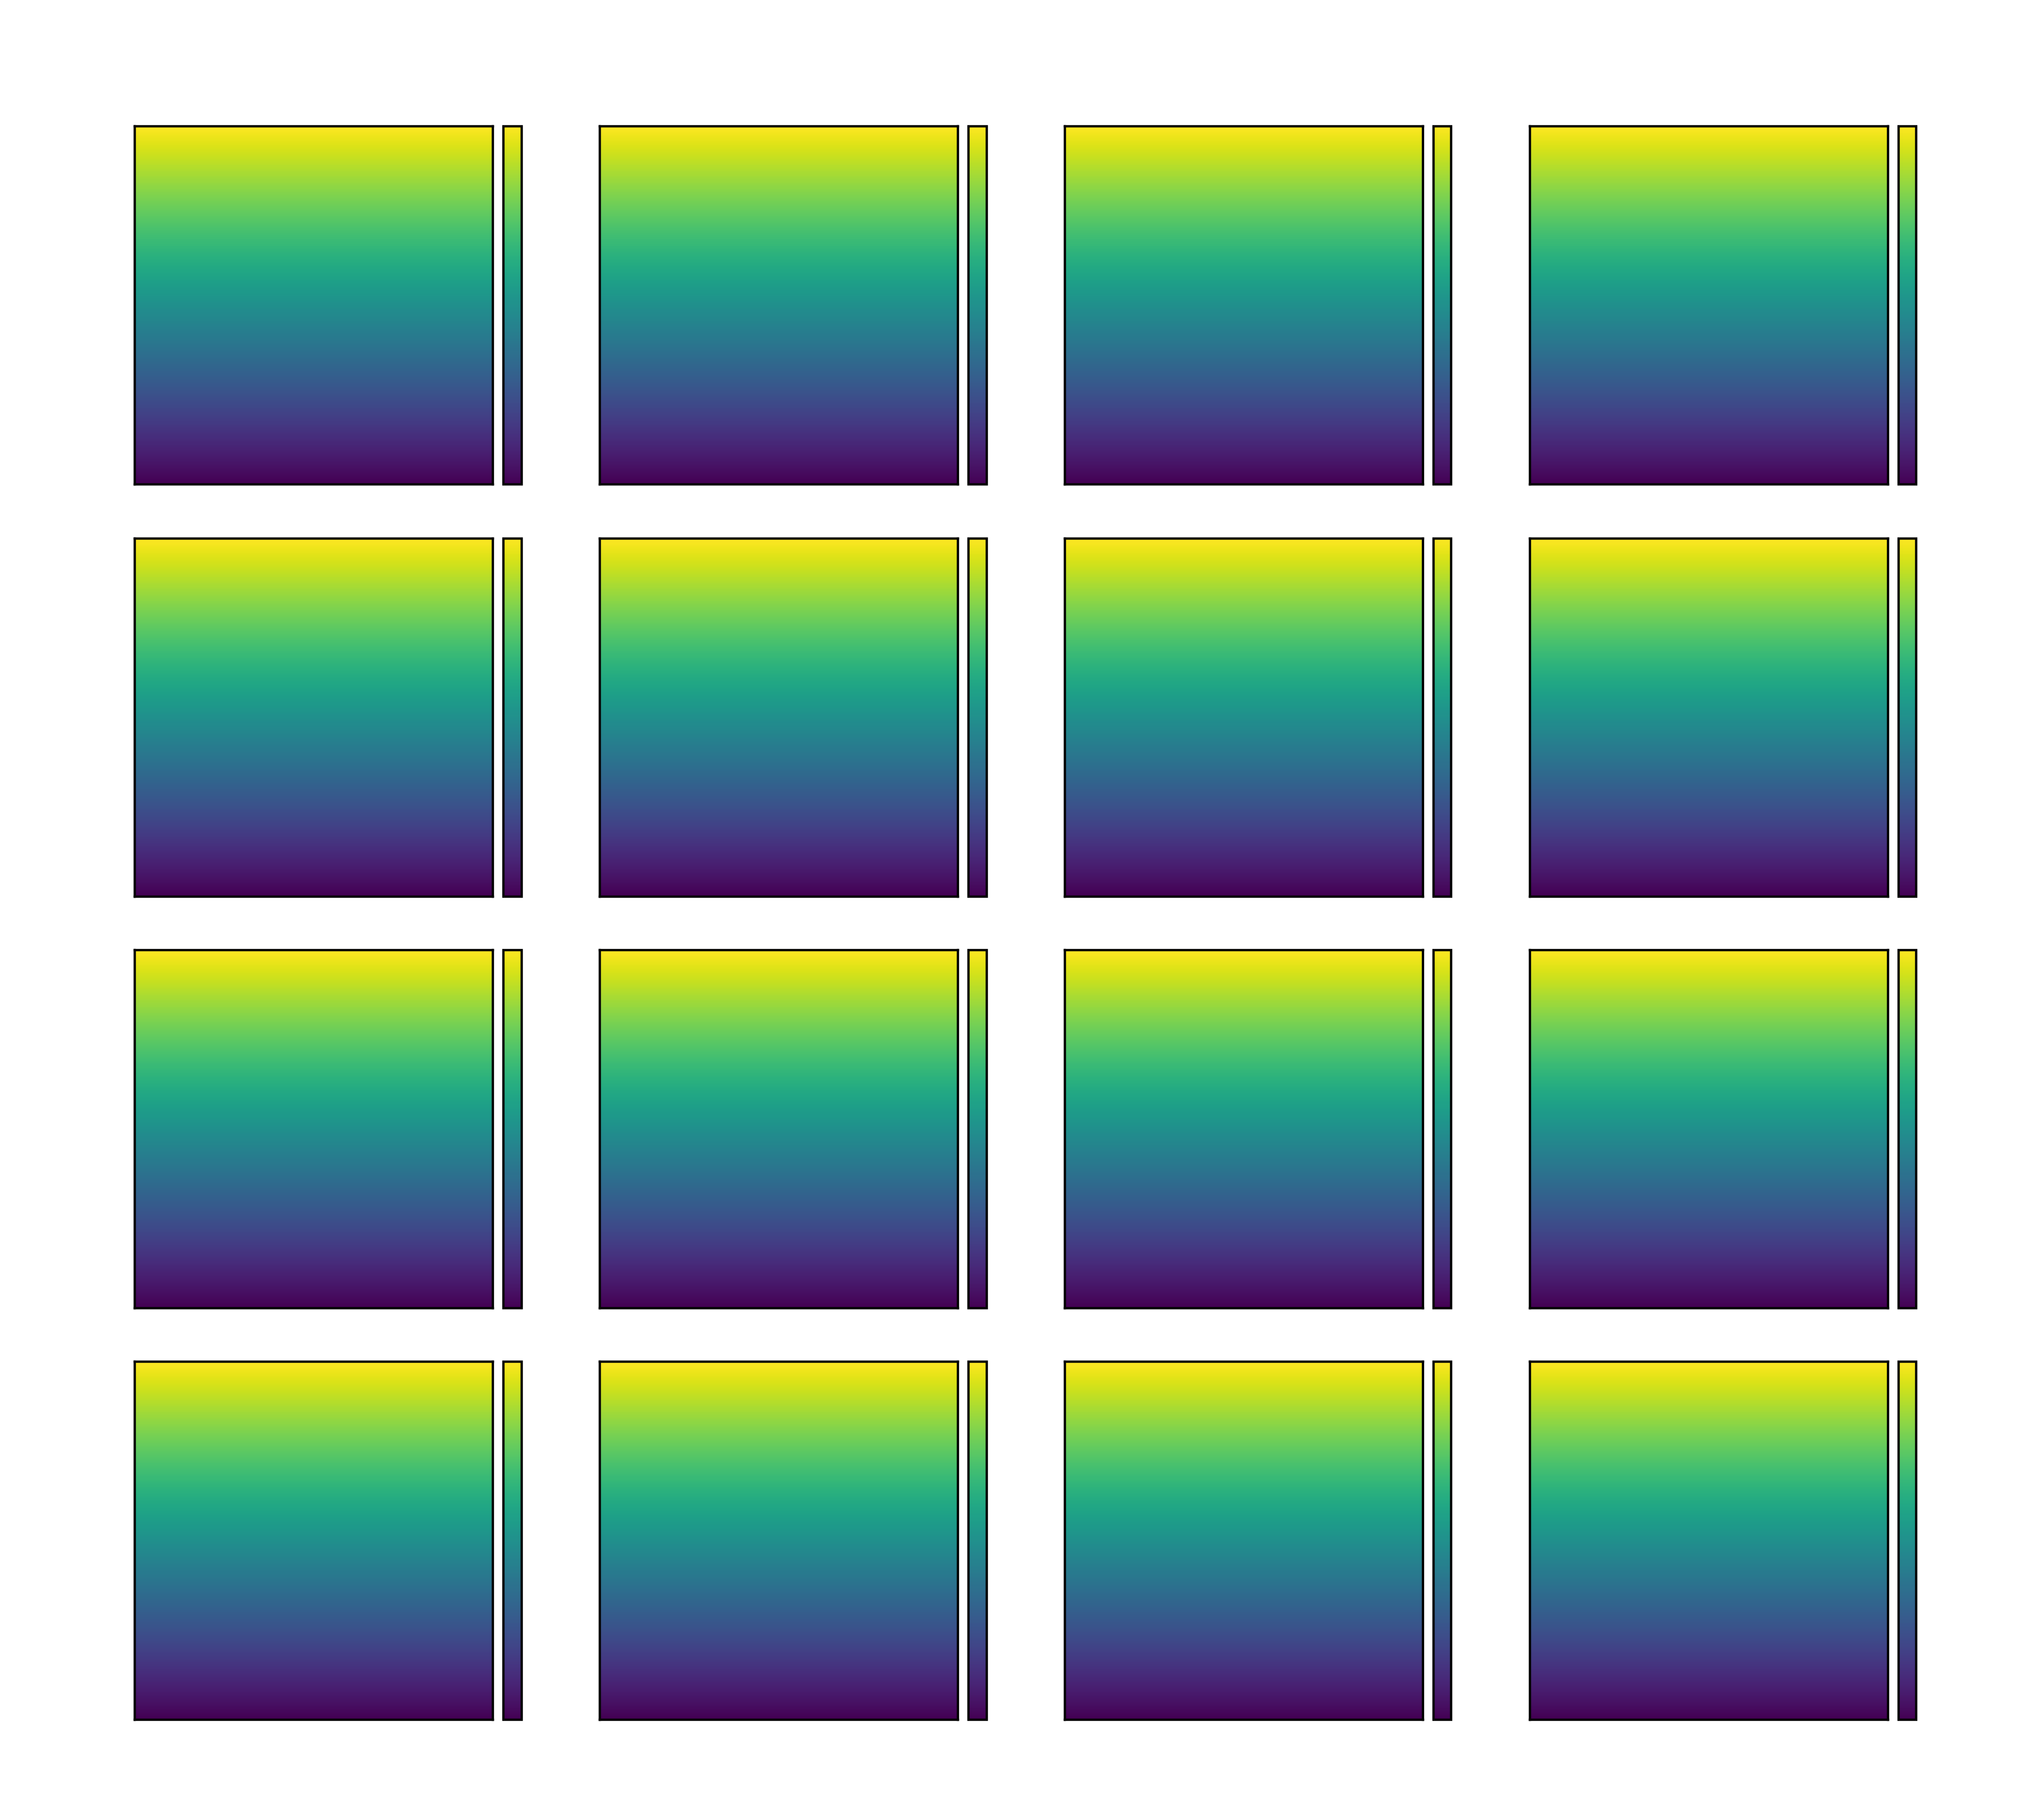

In [98]:
eps_zz_vals = np.linspace(-1., 1., 16)*sigma
eps_zz_3Dmesh, omega_tau_3Dmesh, omega_t_3Dmesh = np.meshgrid(eps_zz_vals,
                                                              omega_t,
                                                              omega_tau,
                                                              indexing='ij')

print(np.shape(omega_tau_3Dmesh))

_ = slices_plots(omega_tau_3Dmesh,
                 shared_title=r'$\omega_\tau$ 3D mesh',
                 titles=[r'$\epsilon_{zz} =$'
                         f'{i:.2e}' for i in eps_zz_vals])

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/2013719190.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "rho" failed type inference due to: Invalid use of type(CPUDispatcher(<function Delta_gs at 0x7fdd5901e8b0>)) with parameters (float64, float64, float64, float64, float64)

During: resolving callee type: type(CPUDispatcher(<function Delta_gs at 0x7fdd5901e8b0>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/2013719190.py (13)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/2013719190.py", line 13:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/2013719190.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "rho" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.Li

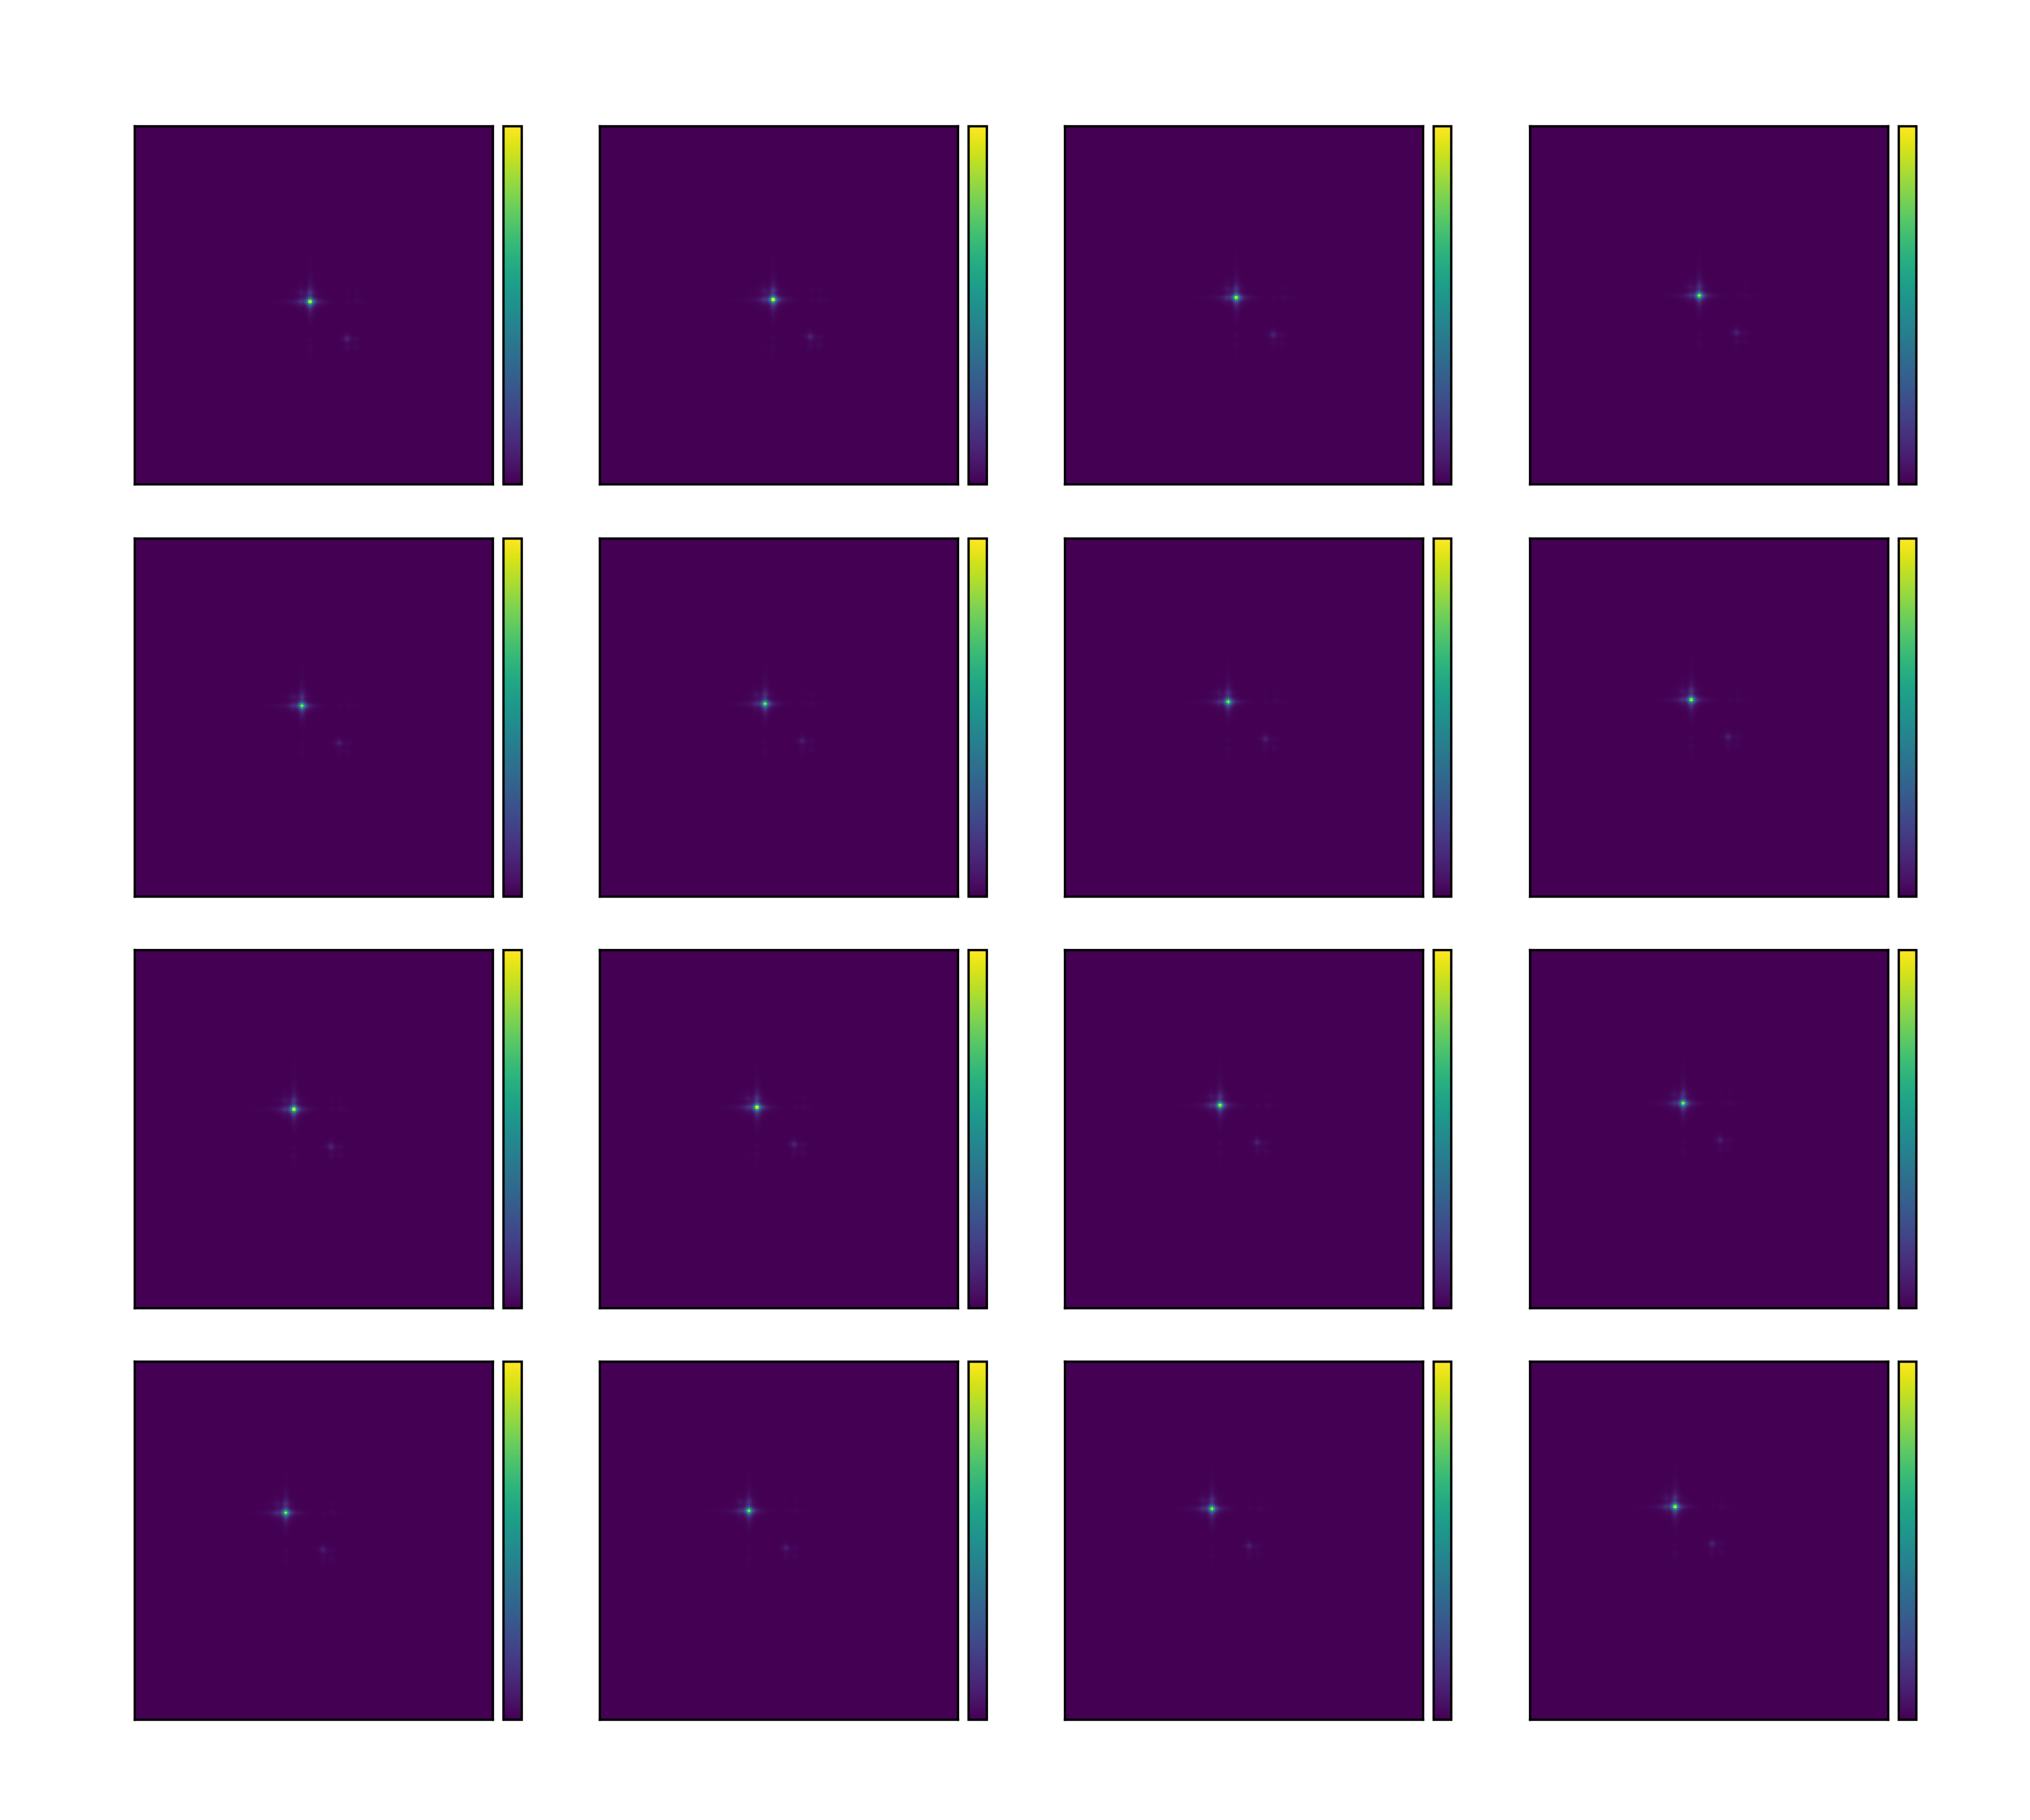

In [99]:
RHOs = rho(omega_t_3Dmesh, 
           omega_tau_3Dmesh, 
           eps_zz=eps_zz_3Dmesh)

_ = slices_plots(abs2(RHOs),
                 shared_title=r'$|\rho|^2$', 
                 titles = [r'$\epsilon_{zz} =$' 
                           f'{i:.2e}' for i in eps_zz_vals])

# Randomly varying all 6 strain indices

\begin{align}\label{eq:aa}
    I_{rand6}\left(\omega_t, \omega_\tau \right) \propto
    & \int \dots \int^{\infty}_{-\infty} d \epsilon_{xx} d \epsilon_{yy} d \epsilon_{zz} d \epsilon_{yz} d \epsilon_{xy} d \epsilon_{zx} \\ 
    & \frac{1}{ \left( \sigma \sqrt{2 \pi} \right)^6 } exp \left[ \frac{-\epsilon_{xx}^2 -\epsilon_{yy}^2 -\epsilon_{zz}^2 -\epsilon_{yz}^2 -\epsilon_{xy}^2 -\epsilon_{zx}^2}{2 \sigma^2} \right] \\ 
    & \rho \left(\omega_t, \omega_{\tau}, \epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx} \right)
\end{align}

# Monte Carlo Integration

\begin{equation}\label{eq:}
\bar{x} \in \{ x_1, x_2, x_3, \dots\}
\end{equation}


\begin{align}\label{eq:28}
f(\bar{x})&: \text{function to be integrated} \\
p(\bar{x})&: \text{probability distribution function / weighing function for our weighted sum (integral)} \\
\frac{p(\bar{x})}{\int_{\bar{x_a}}^{\bar{x_b}}p(\bar{x}) \, d\bar{x}}&: \text{normalized} \, p(\bar{x}) \\
g(\bar{x})&\equiv \frac{f(\bar{x})}{p(\bar{x})} \int_{\bar{x_a}}^{\bar{x_b}}p(\bar{x}) \, d\bar{x}
\end{align}


\begin{align}\label{eq:28a}
\int_{\bar{x_a}}^{\bar{x_b}} f(\bar{x}) \, d\bar{x}
&= \frac{\int_{\bar{x_a}}^{\bar{x_b}}p(\bar{x}) \, d\bar{x}}{\int_{\bar{x_a}}^{\bar{x_b}}p(\bar{x}) \, d\bar{x}} \int_{\bar{x_a}}^{\bar{x_b}} \frac{p(\bar{x})}{p(\bar{x})} \, f(\bar{x}) \, d\bar{x} \\
&= \frac{1}{\int_{\bar{x_a}}^{\bar{x_b}}p(\bar{x}) \, d\bar{x}} \int_{\bar{x_a}}^{\bar{x_b}} p(\bar{x}) \, g(\bar{x}) \, d\bar{x} \\
&= \left \langle g(\bar{x}) \right \rangle_p
\end{align}


\begin{align}\label{eq:8}
\int_{\bar{x_a}}^{\bar{x_b}} f(\bar{x}) \, d\bar{x}
& = \left \langle \frac{f(\bar{x})}{p(\bar{x})} \right \rangle_p \int_{\bar{x_a}}^{\bar{x_b}}p(\bar{x}) \, d\bar{x} \\
& = \lim_{N \to \infty} \frac{1}{N} \sum_i^N \frac{f(\bar{x}_i)}{p(\bar{x}_i)} \int_{\bar{x_a}}^{\bar{x_b}} p(\bar{x}) \, d\bar{x} \\
& \approx \frac{1}{N} \sum_i^N \frac{f(\bar{x}_i)}{p(\bar{x}_i)} \int_{\bar{x_a}}^{\bar{x_b}} p(\bar{x}) \, d\bar{x}
\end{align}

## random numbers drawn from p(x)

\begin{equation}\label{eq:9}
f \left(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx} \right) = \frac{1}{ \left( \sigma \sqrt{2 \pi} \right)^6 } exp \left[ \frac{-\epsilon_{xx}^2 -\epsilon_{yy}^2 -\epsilon_{zz}^2 -\epsilon_{yz}^2 -\epsilon_{xy}^2 -\epsilon_{zx}^2}{2 \sigma^2} \right] \rho \left(\omega_t, \omega_{\tau}, \epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}\right)
\end{equation}


\begin{equation}\label{eq:10}
p \left (\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx} \right) = \frac{1}{ \left( \sigma \sqrt{2 \pi} \right)^6 } exp \left[ \frac{-\epsilon_{xx}^2 -\epsilon_{yy}^2 -\epsilon_{zz}^2 -\epsilon_{yz}^2 -\epsilon_{xy}^2 -\epsilon_{zx}^2}{2 \sigma^2} \right]
\end{equation}


\begin{equation}\label{eq:12}
\int \dots \int^{\infty}_{-\infty} d \epsilon_{xx} d \epsilon_{yy} d \epsilon_{zz} d \epsilon_{yz} d \epsilon_{xy} d \epsilon_{zx} \, p \left (\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx} \right) = 1
\end{equation}


\begin{align}\label{eq:14}
 I_{rand6}(\omega_t, \omega_\tau)
& \propto \left \langle \frac{f(\bar{\epsilon})}{p \left(\bar{\epsilon} \right)} \right \rangle_p \int_{\bar{\epsilon_a}}^{\bar{\epsilon_b}}p(\bar{\epsilon}) \, d\bar{\epsilon} \\
& \tilde{\propto} \frac{1}{N} \sum_i^N \frac{f(\bar{\epsilon}_i)}{p(\bar{\epsilon}_i)} \\
& \tilde{\propto} \frac{1}{N} \sum_i^N \rho \left (\omega_t, \omega_{\tau}, \epsilon_{xx_i}, \epsilon_{yy_i}, \epsilon_{zz_i}, \epsilon_{yz_i}, \epsilon_{xy_i}, \epsilon_{zx_i} \right) \\
\end{align}

In [100]:
@numba.jit
def rand6_MCint(
        omega_t=omega_t,
        omega_tau=omega_tau,
        MC_N=MC_N  # MC Steps
):

    randn_eps = sigma * np.random.randn(6, MC_N)  # normal distribution

    I_rand6 = 1.j * np.zeros((res, res))

    if MC_N >= res**2:

        # looping over omega mesh, equivalent to the below, tends to be faster if MC_N > res^2
        for i, om_t in enumerate(omega_t):
            for j, om_tau in enumerate(omega_tau):
                I_rand6[j, i] = np.mean(
                    rho(om_t, om_tau, randn_eps[0], randn_eps[1], randn_eps[2],
                        randn_eps[3], randn_eps[4], randn_eps[5]))

    else:

        # looping over MC stemp, equivalent to the top, tends to be faster if MC_N < res^2
        for i in range(MC_N):
            I_rand6 += rho(omega_t_mesh, omega_tau_mesh, randn_eps[0, i],
                           randn_eps[1, i], randn_eps[2, i], randn_eps[3, i],
                           randn_eps[4, i], randn_eps[5, i])

    return I_rand6 / np.sqrt(np.max(abs2(I_rand6)))

In [101]:
I_random6 = rand6_MCint()

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/3074145185.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "rand6_MCint" failed type inference due to: Invalid use of type(CPUDispatcher(<function rho at 0x7fdd59023670>)) with parameters (float64, float64, array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C))

During: resolving callee type: type(CPUDispatcher(<function rho at 0x7fdd59023670>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/3074145185.py (18)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/3074145185.py", line 18:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/3074145185.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because

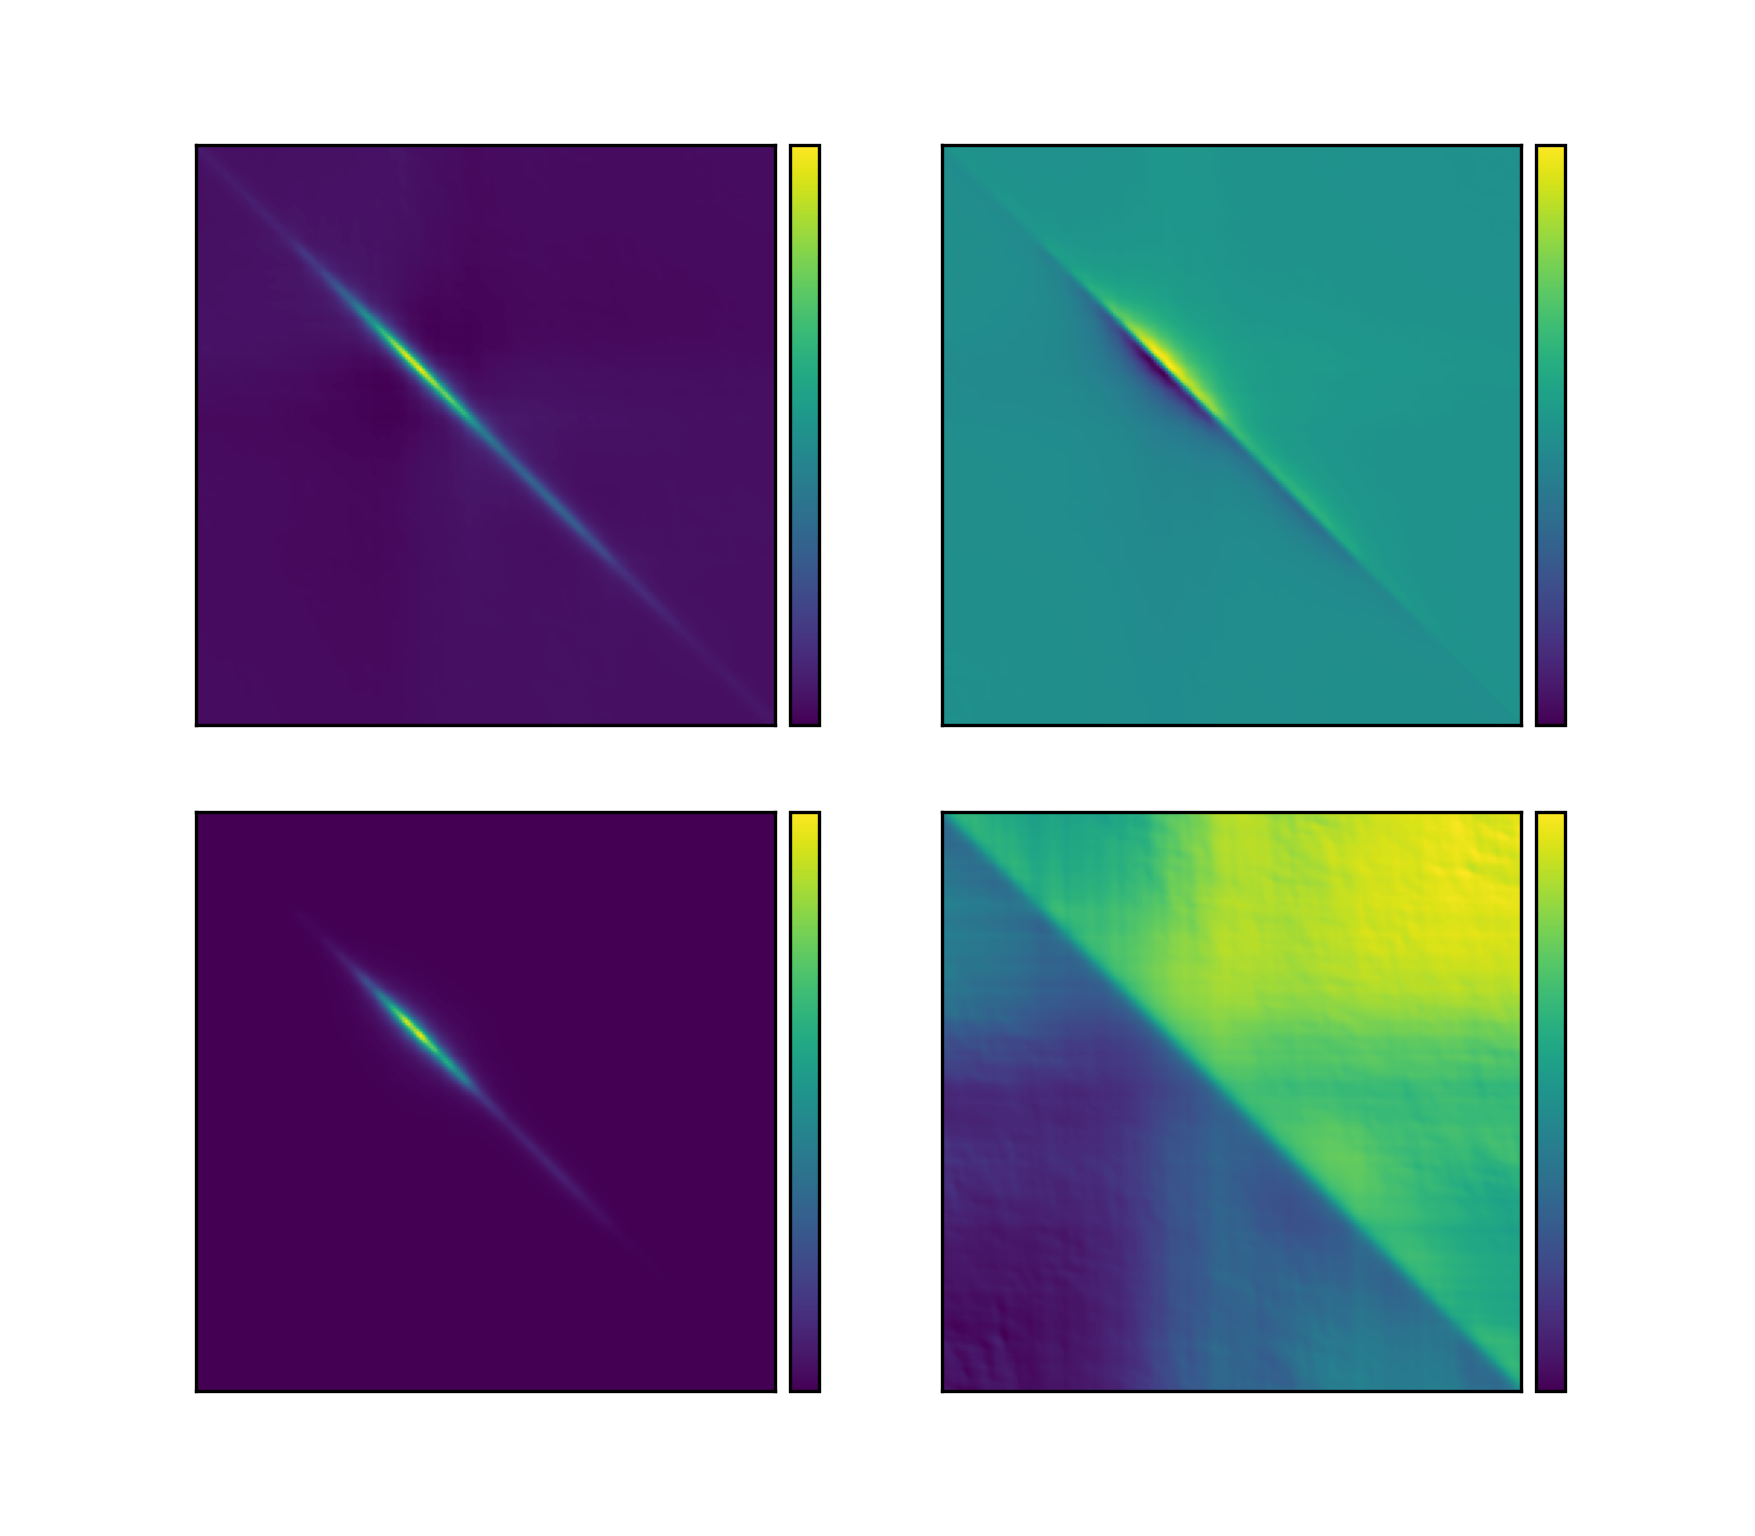

In [102]:
I_random6_ReImAmPh = np.array([I_random6.real, I_random6.imag, abs2(I_random6), phase(I_random6)])
fig_random6 = slices_plots(I_random6_ReImAmPh, 
                      shared_title='Randomly varying all 6 strain indices', 
                      shared_title_y_position=0.95,
                      figure_shape=[2,2], 
                      figure_size=[6,5.5],
                      titles=[r'$\mathfrak{R} \left\{I_{rand6} (\omega_t, \omega_\tau) \right\}$', 
                              r'$\mathfrak{I} \left\{I_{rand6} (\omega_t, \omega_\tau) \right\}$',
                              r'$             \left |I_{rand6} (\omega_t, \omega_\tau) \right |^2$',
                              r'$     \varphi \left (I_{rand6} (\omega_t, \omega_\tau) \right )$'],
                      horizontal_gap=0.15,
                      shared_y_label_x_position=0.04, 
                      shared_x_label_y_position=0.06)

https://stackoverflow.com/questions/14071704/integrating-a-multidimensional-integral-in-scipy

https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.nquad.html

# ε_zz in random directions

\[
R_z(\phi) \, R_x(\theta) \,
\begin{pmatrix}
p \, \epsilon_{zz_0} & 0 & 0\\
0 & p \, \epsilon_{zz_0} & 0\\
0 & 0 & \epsilon_{zz_0}\\
\end{pmatrix}
\, R_x^T(\theta) \, R_z^T(\phi)
\]

\[
\begin{pmatrix}
\cos{\phi} & - \sin{\phi} & 0\\
\sin{\phi} & \cos{\phi} & 0\\
0 & 0 & 1\\
\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0\\
0 & \cos{\theta} & - \sin{\theta}\\
0 & \sin{\theta} & \cos{\theta}\\
\end{pmatrix}
\begin{pmatrix}
p \, \epsilon_{zz_0} & 0 & 0\\
0 & p \, \epsilon_{zz_0} & 0\\
0 & 0 & \epsilon_{zz_0}\\
\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0\\
0 & \cos{\theta} & \sin{\theta}\\
0 & - \sin{\theta} & \cos{\theta}\\
\end{pmatrix}
\begin{pmatrix}
\cos{\phi} & \sin{\phi} & 0\\
- \sin{\phi} & \cos{\phi} & 0\\
0 & 0 & 1\\
\end{pmatrix}
\]

\[
\begin{pmatrix}
\left [p \, \cos^2{\phi} + \sin^2{\phi}\left (p \, \cos^2{\theta} + \sin^2{\theta} \right ) \right ]\epsilon_{zz_0} & \left( p - 1 \right) \frac{\sin{2 \phi}}{2} \, \sin^2{\theta} \, \epsilon_{zz_0} & \left( 1 - p \right) \sin{\phi} \, \frac{\sin{2 \theta}}{2} \epsilon_{zz_0}\\
\left( p - 1 \right) \frac{\sin{2 \phi}}{2} \, \sin^2{\theta} \, \epsilon_{zz_0} & \left [p \, \sin^2{\phi} + \cos^2{\phi}\left (p \, \cos^2{\theta} + \sin^2{\theta} \right ) \right ]\epsilon_{zz_0} & \left( p - 1 \right) \cos{\phi} \, \frac{\sin{2 \theta}}{2} \epsilon_{zz_0}\\
\left( 1 - p \right) \sin{\phi} \, \frac{\sin{2 \theta}}{2} \epsilon_{zz_0} & \left( p - 1 \right) \cos{\phi} \, \frac{\sin{2 \theta}}{2} \epsilon_{zz_0} & \left (\cos^2{\theta} + p \, \sin^2{\theta} \right )\epsilon_{zz_0}\\
\end{pmatrix}
\]

\begin{equation}\label{eq:21}
\epsilon'_{xx} \left (  \epsilon_{zz_0}, \theta, \phi \right ) = \left [p \, \cos^2{\phi} + \sin^2{\phi}\left (p \, \cos^2{\theta} + \sin^2{\theta} \right ) \right ]\epsilon_{zz_0}
\end{equation}

In [103]:
@numba.jit
def eps_xx_p(eps_zz_0, 
             theta,
             phi):
    
    return ( poi*np.cos(phi)**2. + np.sin(phi)**2.*(poi*np.cos(theta)**2. + np.sin(theta)**2.) )*eps_zz_0

\begin{equation}\label{eq:22}
\epsilon'_{yy} \left (  \epsilon_{zz_0}, \theta, \phi \right ) = \left [p \, \sin^2{\phi} + \cos^2{\phi}\left (p \, \cos^2{\theta} + \sin^2{\theta} \right ) \right ]\epsilon_{zz_0}
\end{equation}

In [104]:
@numba.jit
def eps_yy_p(eps_zz_0, 
             theta,
             phi):
    
    return ( poi*np.sin(phi)**2. + np.cos(phi)**2.*(poi*np.cos(theta)**2. + np.sin(theta)**2.) )*eps_zz_0

\begin{equation}\label{eq:23}
\epsilon'_{zz} \left (  \epsilon_{zz_0}, \theta, \phi \right ) = \left (\cos^2{\theta} + p \, \sin^2{\theta} \right )\epsilon_{zz_0}
\end{equation}

In [105]:
@numba.jit
def eps_zz_p(eps_zz_0, 
             theta,
             phi):
    
    return (np.cos(theta)**2. + poi*np.sin(theta)**2.)*eps_zz_0

\begin{equation}\label{eq:24}
\epsilon'_{yz} \left (  \epsilon_{zz_0}, \theta, \phi \right ) = \left( p - 1 \right) \cos{\phi} \, \frac{\sin{2 \theta}}{2} \epsilon_{zz_0}
\end{equation}

In [106]:
@numba.jit
def eps_yz_p(eps_zz_0, 
             theta,
             phi):
    
    return (poi - 1.) * np.cos(phi) * np.sin(2.*theta)/2. * eps_zz_0

\begin{equation}\label{eq:25}
\epsilon'_{xy} \left (  \epsilon_{zz_0}, \theta, \phi \right ) = \left( p - 1 \right) \frac{\sin{2 \phi}}{2} \, \sin^2{\theta} \, \epsilon_{zz_0}
\end{equation}

In [107]:
@numba.jit
def eps_xy_p(eps_zz_0, 
             theta,
             phi):
    
    return (poi - 1.) * np.sin(2.*phi)/2. * np.sin(theta)**2. * eps_zz_0

\begin{equation}\label{eq:26}
\epsilon'_{zx} \left (  \epsilon_{zz_0}, \theta, \phi \right ) = \left( 1 - p \right) \sin{\phi} \, \frac{\sin{2 \theta}}{2} \epsilon_{zz_0}
\end{equation}

In [108]:
@numba.jit
def eps_zx_p(eps_zz_0, 
             theta,
             phi):
    
    return (1. - poi) * np.sin(phi) * np.sin(2.*theta)/2. * eps_zz_0

\begin{align}\label{eq:27}
    I_{randDir}(\omega_t, \omega_\tau) 
    & \propto \int^{\infty}_{-\infty} d \epsilon_{zz_0} \int_0^\pi \sin{\theta} \, d \theta \int_0^{2\pi} d \phi \frac{1}{ \sigma \sqrt{2 \pi} } exp \left[ \frac{-\epsilon_{zz_0}^2}{2 \sigma^2} \right] \, \rho \left (\omega_t, \omega_{\tau}, \bar{\epsilon}'_{ij} \left (  \epsilon_{zz_0}, \theta, \phi \right ) \right) \\
    & \propto \int^{\infty}_{-\infty} d \epsilon_{zz_0} \int_0^\pi \sin{\theta} \, d \theta \int_0^{2\pi} d \phi \frac{1}{ \sigma \sqrt{2 \pi} } exp \left[ \frac{-\epsilon_{zz_0}^2}{2 \sigma^2} \right] \, \rho \left (\omega_t, \omega_{\tau},   \epsilon_{zz_0}, \theta, \phi \right )
\end{align}

# Monte Carlo Integration

\begin{equation}\label{eq:31}
\bar{x} \in \{ x_1, x_2, x_3, \dots\}
\end{equation}


\begin{align}\label{eq:29}
\int_{\bar{x_a}}^{\bar{x_b}} f(\bar{x}) \, d\bar{x}
& = \left \langle \frac{f(\bar{x})}{p(\bar{x})} \right \rangle_p \int_{\bar{x_a}}^{\bar{x_b}}p(\bar{x}) \, d\bar{x} \\
& = \lim_{N \to \infty} \frac{1}{N} \sum_i^N \frac{f(\bar{x}_i)}{p(\bar{x}_i)} \int_{\bar{x_a}}^{\bar{x_b}} p(\bar{x}) \, d\bar{x} \\
& \approx \frac{1}{N} \sum_i^N \frac{f(\bar{x}_i)}{p(\bar{x}_i)} \int_{\bar{x_a}}^{\bar{x_b}} p(\bar{x}) \, d\bar{x}
\end{align}

\begin{equation}\label{eq:32}
f\left( \epsilon_{zz_0}, \theta, \phi \right) = \sin{\theta} \frac{1}{ \sigma \sqrt{2 \pi} } exp \left[ \frac{-\epsilon_{zz_0}^2}{2 \sigma^2} \right] \, \rho \left (\omega_t, \omega_{\tau}, \epsilon_{zz_0}, \theta, \phi \right )
\end{equation}

\begin{equation}\label{eq:33}
p\left( \epsilon_{zz_0}, \theta, \phi \right) = \sin{\theta} \frac{1}{ \sigma \sqrt{2 \pi} } exp \left[ \frac{-\epsilon_{zz_0}^2}{2 \sigma^2} \right]
\end{equation}

\begin{equation}\label{eq:34}
\int^{\infty}_{-\infty} d \epsilon_{zz_0} \int_0^\pi d \theta \int_0^{2\pi} d \phi \, p\left( \epsilon_{zz_0}, \theta, \phi \right) = 4 \pi
\end{equation}


\begin{align}\label{eq:35}
 I_{randDir}(\omega_t, \omega_\tau)
& \propto \left \langle \frac{f\left( \epsilon_{zz_0}, \theta, \phi \right)}{p\left( \epsilon_{zz_0}, \theta, \phi \right)} \right \rangle_p \int^{\infty}_{-\infty} d \epsilon_{zz_0} \int_0^\pi d \theta \int_0^{2\pi} d \phi \, p\left( \epsilon_{zz_0}, \theta, \phi \right) \\
& \tilde{\propto} \frac{1}{N} \sum_i^N \frac{f\left( \epsilon_{zz_0i}, \theta_i, \phi_i \right)}{p\left( \epsilon_{zz_0i}, \theta_i, \phi_i \right)} \, 4 \pi \\
& \tilde{\propto} \frac{4 \pi}{N} \sum_i^N \rho \left (\omega_t, \omega_{\tau}, \epsilon_{zz_0i}, \theta_i, \phi_i \right ) \\
\end{align}

In [109]:
@numba.jit
def randDir_MCint(
        omega_t=omega_t,
        omega_tau=omega_tau,
        MC_N=MC_N  # MC Steps
):

    randn_eps_zz_0 = sigma * np.random.randn(MC_N)  # normal distribution
    rand_theta = np.arccos(
        2. * np.random.rand(MC_N) -
        1.)  # dcos(theta) uniform distribution, not theta unifrom
    rand_phi = 2. * np.pi * np.random.rand(MC_N)

    I_randDir = 1.j * np.zeros((res, res))

    if MC_N >= res**2:

        # looping over omega mesh, equivalent to the below, tends to be faster if MC_N > res^2
        for i, om_t in enumerate(omega_t):
            for j, om_tau in enumerate(omega_tau):
                I_randDir[j, i] = np.mean(
                    rho(om_t,
                        om_tau,
                        eps_xx=eps_xx_p(randn_eps_zz_0, rand_theta, rand_phi),
                        eps_yy=eps_yy_p(randn_eps_zz_0, rand_theta, rand_phi),
                        eps_zz=eps_zz_p(randn_eps_zz_0, rand_theta, rand_phi),
                        eps_yz=eps_yz_p(randn_eps_zz_0, rand_theta, rand_phi),
                        eps_xy=eps_xy_p(randn_eps_zz_0, rand_theta, rand_phi),
                        eps_zx=eps_zx_p(randn_eps_zz_0, rand_theta, rand_phi)))
                
    else:
        
        # looping over MC stemp, equivalent to the top, tends to be faster if MC_N < res^2
        for i in range(MC_N):
            I_randDir += rho(omega_t_mesh, 
                             omega_tau_mesh,
                             eps_xx=eps_xx_p(randn_eps_zz_0[i], rand_theta[i], rand_phi[i]),
                             eps_yy=eps_yy_p(randn_eps_zz_0[i], rand_theta[i], rand_phi[i]),
                             eps_zz=eps_zz_p(randn_eps_zz_0[i], rand_theta[i], rand_phi[i]),
                             eps_yz=eps_yz_p(randn_eps_zz_0[i], rand_theta[i], rand_phi[i]),
                             eps_xy=eps_xy_p(randn_eps_zz_0[i], rand_theta[i], rand_phi[i]),
                             eps_zx=eps_zx_p(randn_eps_zz_0[i], rand_theta[i], rand_phi[i]))
    
    return I_randDir / np.sqrt(np.max(abs2(I_randDir)))

In [110]:
I_randomDir = randDir_MCint()

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/2061869005.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "randDir_MCint" failed type inference due to: Invalid use of type(CPUDispatcher(<function rho at 0x7fdd59023670>)) with parameters (float64, float64, eps_xx=array(float64, 1d, C), eps_xy=array(float64, 1d, C), eps_yy=array(float64, 1d, C), eps_yz=array(float64, 1d, C), eps_zx=array(float64, 1d, C), eps_zz=array(float64, 1d, C))

During: resolving callee type: type(CPUDispatcher(<function rho at 0x7fdd59023670>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/2061869005.py (22)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/2061869005.py", line 22:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/2061869005.py:1: NumbaWarning: 
Compilation is falling back to obj

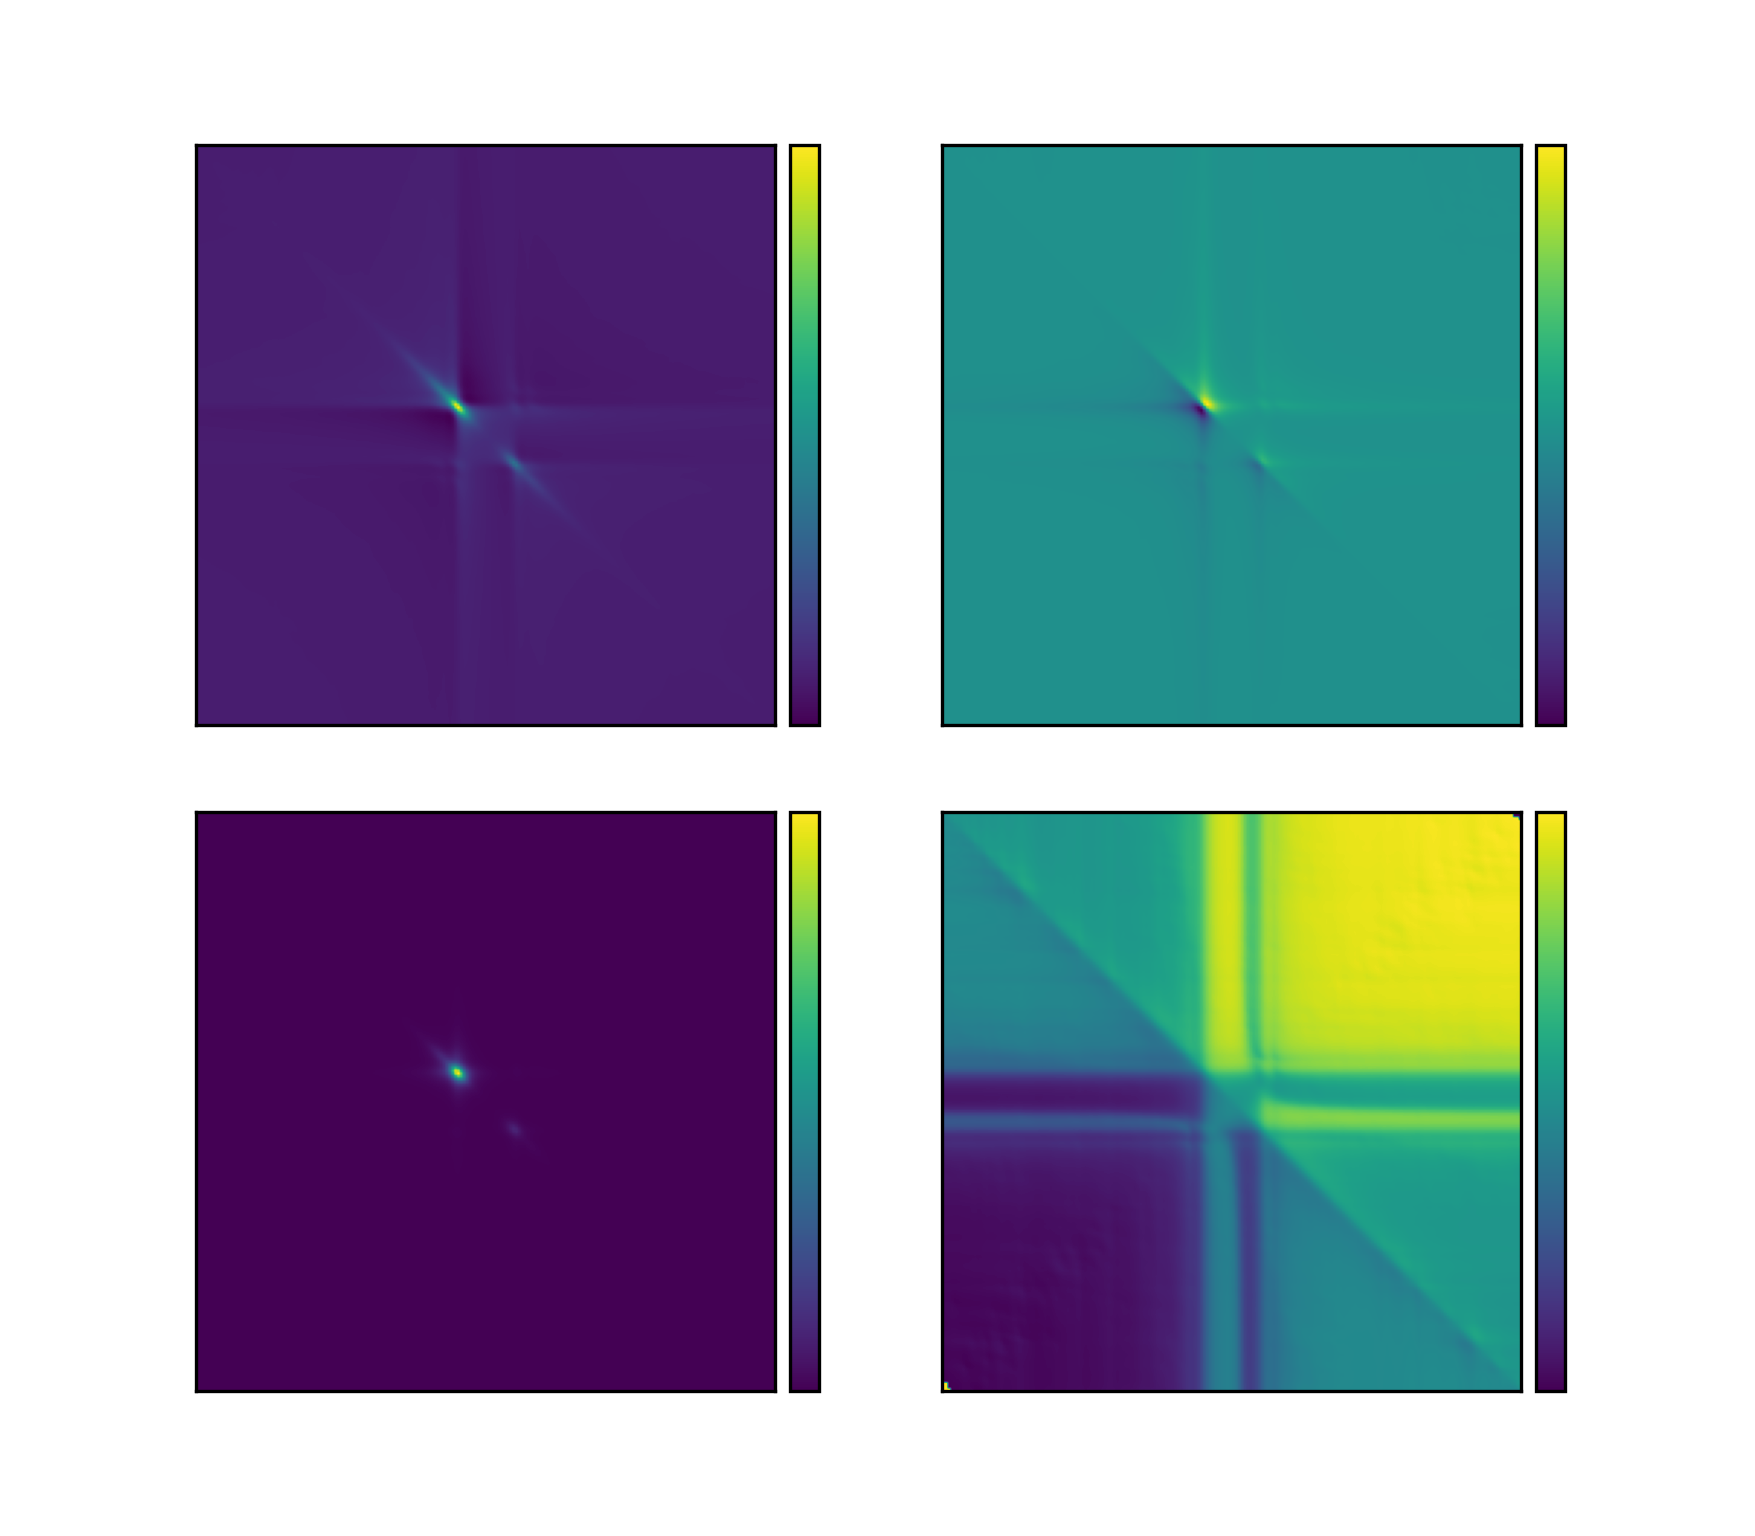

In [111]:
I_randomDir_ReImAmPh = np.array([I_randomDir.real, I_randomDir.imag, abs2(I_randomDir), phase(I_randomDir)])
fig_randomDir = slices_plots(I_randomDir_ReImAmPh, 
                      shared_title='Random ' r'$\epsilon_{zz}$' ' in random directions', 
                      shared_title_y_position=0.95,
                      figure_shape=[2,2], 
                      figure_size=[6,5.5],
                      titles=[r'$\mathfrak{R} \left\{I_{randDir} (\omega_t, \omega_\tau) \right\}$', 
                              r'$\mathfrak{I} \left\{I_{randDir} (\omega_t, \omega_\tau) \right\}$',
                              r'$             \left |I_{randDir} (\omega_t, \omega_\tau) \right |^2$',
                              r'$     \varphi \left (I_{randDir} (\omega_t, \omega_\tau) \right )$'],
                      horizontal_gap=0.15,
                      shared_y_label_x_position=0.04, 
                      shared_x_label_y_position=0.06)

# Istropic Strain

\[
\epsilon = \epsilon_0
\begin{pmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1\\
\end{pmatrix}
\]

\begin{equation}\label{eq:46a}
    I_{iso}\left(\omega_t, \omega_\tau, p=0 \right) \propto \int^{\infty}_{-\infty} d \epsilon_{0} \frac{1}{ \sigma \sqrt{2 \pi} } exp \left[ \frac{-\epsilon_{0}^2}{2 \sigma^2} \right] \, \rho \left(\omega_t, \omega_{\tau}, \epsilon_{xx} = \epsilon_{yy} =  \epsilon_{zz}= \epsilon_0 \right)
\end{equation}

## Because the strain matrix is proportional to the identity, there is no need to rotate into the SiV basis

# computing integral using https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad_vec.html

In [112]:
@numba.jit
def Gaus(eps_ij):
    
    return 1. / sigma / np.sqrt(2. * np.pi) * np.exp(-eps_ij**2. / 2. / sigma**2.)

In [113]:
@numba.jit
def infint(func):
    
    return spint.quad_vec(func, -np.inf, np.inf)

In [114]:
@numba.jit
def iso_MCint(
        omega_t=omega_t,
        omega_tau=omega_tau,
        MC_N=MC_N  # MC Steps
):

    randn_eps_0 = sigma * np.random.randn(MC_N)  # normal distribution

    I_iso = 1.j * np.zeros((res, res))

    if MC_N >= res**2:

        # looping over omega mesh, equivalent to the below, tends to be faster if MC_N > res^2
        for i, om_t in enumerate(omega_t):
            for j, om_tau in enumerate(omega_tau):
                I_iso[j, i] = np.mean(
                    rho(om_t,
                        om_tau,
                        eps_xx=randn_eps_0,
                        eps_yy=randn_eps_0,
                        eps_zz=randn_eps_0))

    else:

        # looping over MC stemp, equivalent to the top, tends to be faster if MC_N < res^2
        for i in range(MC_N):
            I_iso += rho(omega_t_mesh,
                         omega_tau_mesh,
                         eps_xx=randn_eps_0[i],
                         eps_yy=randn_eps_0[i],
                         eps_zz=randn_eps_0[i])
            
    return I_iso / np.sqrt(np.max(abs2(I_iso)))

In [115]:
if MC_all:
    
    I_iso = iso_MCint()
    
else:

    func = lambda eps_0: Gaus(eps_0) * rho(omega_t_mesh, 
                                           omega_tau_mesh, 
                                           eps_xx=eps_0,
                                           eps_yy=eps_0,
                                           eps_zz=eps_0)

    I_iso, int_err_iso = infint(func)

I_iso /= np.sqrt(np.max(abs2(I_iso)))

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/1812531680.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "iso_MCint" failed type inference due to: Invalid use of type(CPUDispatcher(<function rho at 0x7fdd59023670>)) with parameters (float64, float64, eps_xx=array(float64, 1d, C), eps_yy=array(float64, 1d, C), eps_zz=array(float64, 1d, C))

During: resolving callee type: type(CPUDispatcher(<function rho at 0x7fdd59023670>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/1812531680.py (18)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/1812531680.py", line 18:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/1812531680.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "iso_MCint" failed type inference due to

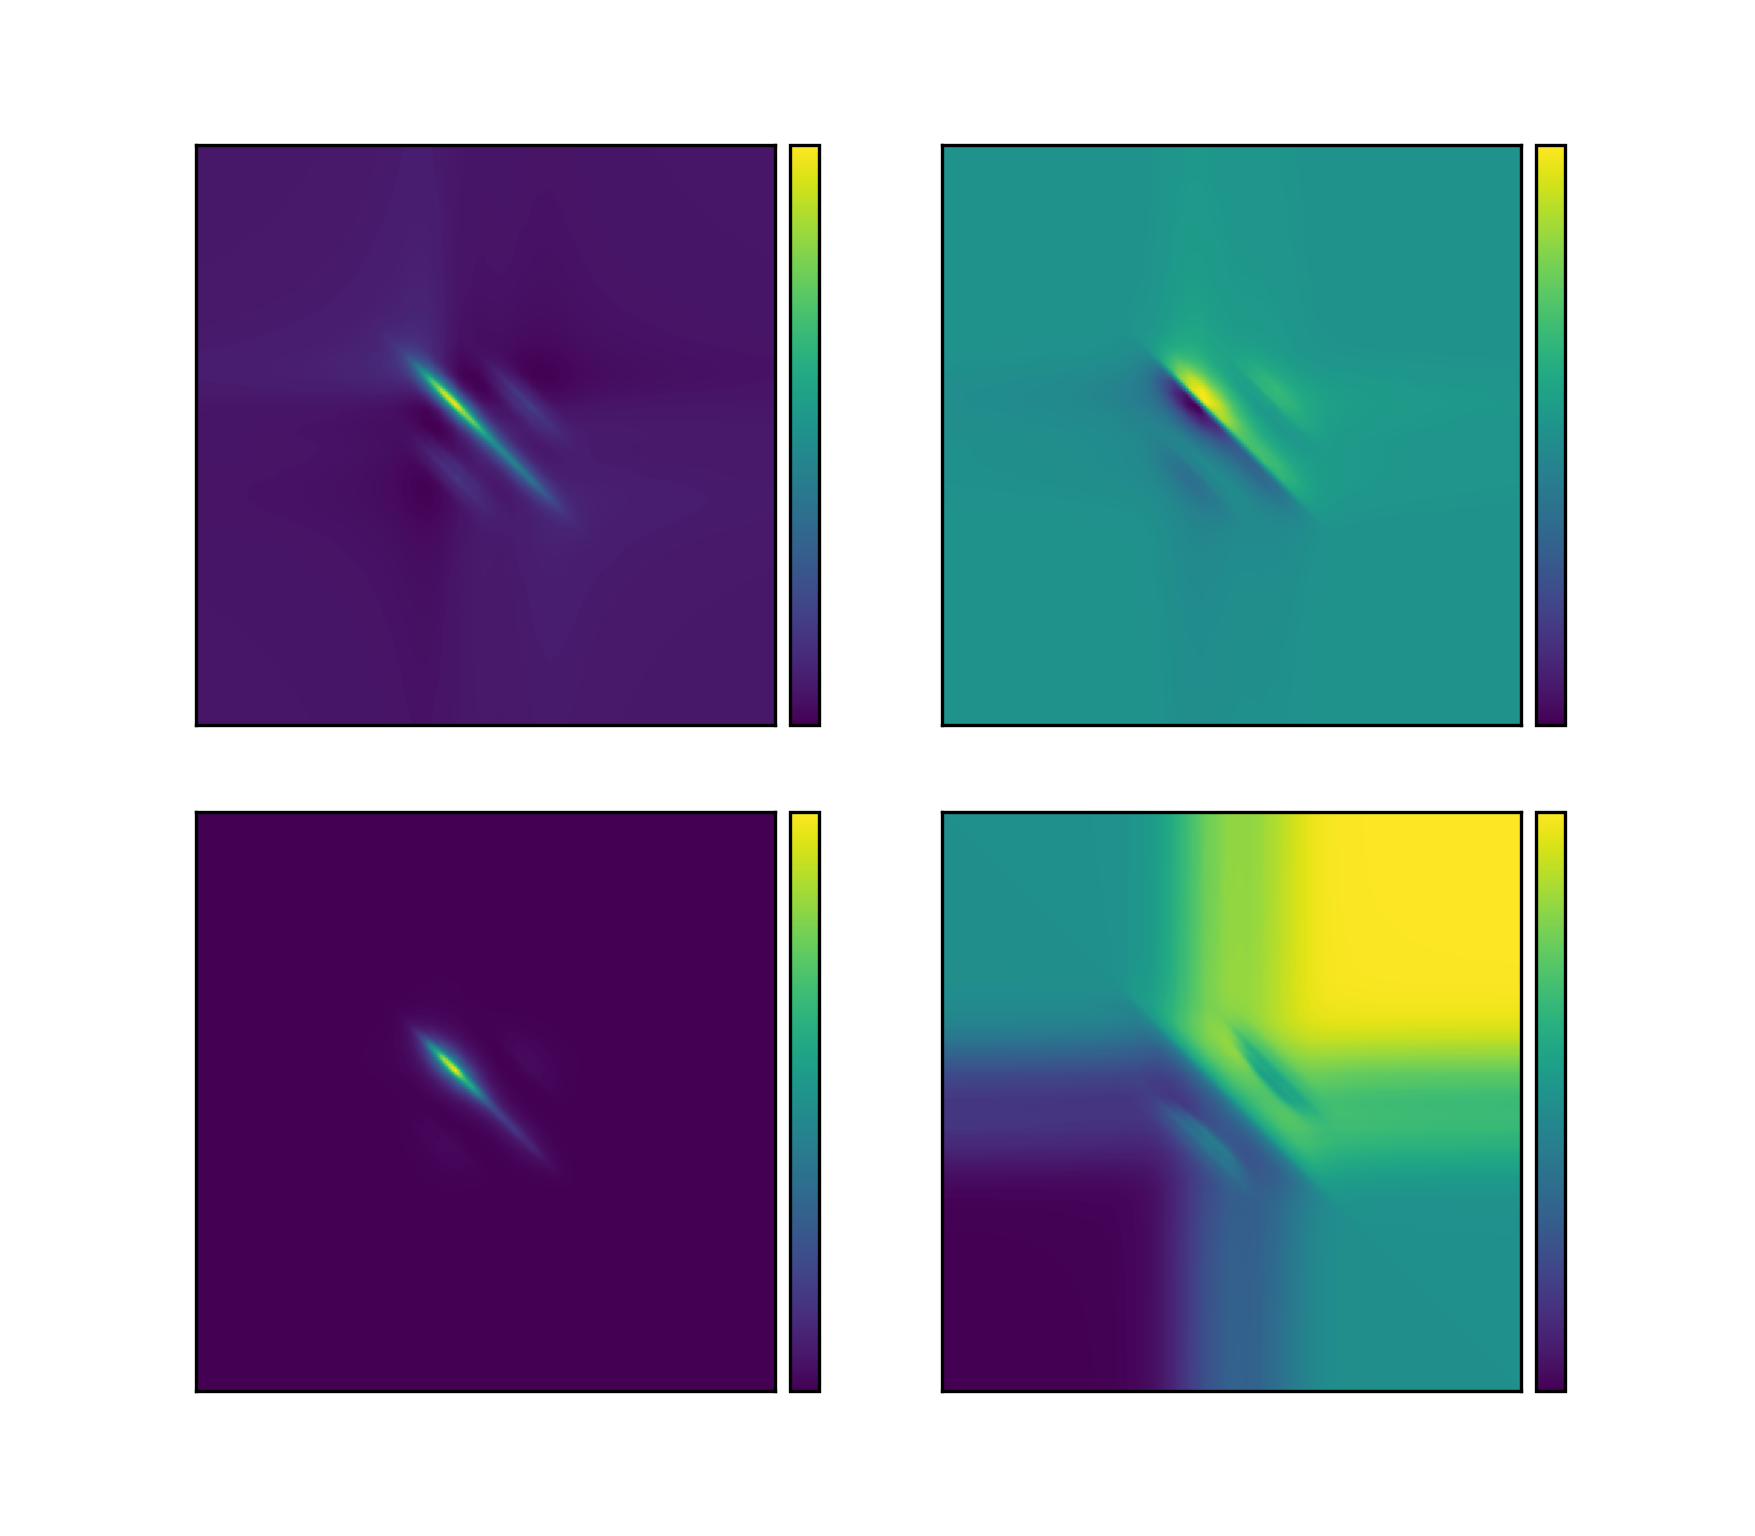

In [116]:
I_iso_ReImAmPh = np.array([I_iso.real, I_iso.imag, abs2(I_iso), phase(I_iso)])
fig_iso = slices_plots(I_iso_ReImAmPh, 
                      shared_title='Isotropic Strain', 
                      shared_title_y_position=0.95,
                      figure_shape=[2,2], 
                      figure_size=[6,5.5],
                      titles=[r'$\mathfrak{R} \left\{I_{iso} (\omega_t, \omega_\tau) \right\}$', 
                              r'$\mathfrak{I} \left\{I_{iso} (\omega_t, \omega_\tau) \right\}$',
                              r'$             \left |I_{iso} (\omega_t, \omega_\tau) \right |^2$',
                              r'$     \varphi \left (I_{iso} (\omega_t, \omega_\tau) \right )$'],
                      horizontal_gap=0.15,
                      shared_y_label_x_position=0.04, 
                      shared_x_label_y_position=0.06)

# Unidirectional Strain

## Unidirectional strain applied along the [1 1 0] directions. No sheer strain. Approximate the strain tensor in the crystal basis ([1 bar{1} 0], [1 1 0], [0 0 1]) as:

\[
\epsilon =
\begin{pmatrix}
p \, \epsilon_{yy_0} & 0 & 0\\
0 & \epsilon_{yy_0} & 0\\
0 & 0 & p \, \epsilon_{yy_0}\\
\end{pmatrix}
\]

## Transverse SiV, orientation 1, cos2θ = -1/3

\[
R_y(\theta) \,
\begin{pmatrix}
p \, \epsilon_{yy_0} & 0 & 0\\
0 & \epsilon_{yy_0} & 0\\
0 & 0 & p \, \epsilon_{yy_0}\\
\end{pmatrix}
\, R_y^T(\theta)
\]

\[
\begin{pmatrix}
\cos{\theta} & 0 & - \sin{\theta}\\
0 & 1 & 0\\
\sin{\theta} & 0 & \cos{\theta}\\
\end{pmatrix}
\begin{pmatrix}
p \, \epsilon_{yy_0} & 0 & 0\\
0 & \epsilon_{yy_0} & 0\\
0 & 0 & p \, \epsilon_{yy_0}\\
\end{pmatrix}
\begin{pmatrix}
\cos{\theta} & 0 & \sin{\theta}\\
0 & 1 & 0\\
- \sin{\theta} & 0 & \cos{\theta}\\
\end{pmatrix}
\]

\[
\begin{pmatrix}
p \, \epsilon_{yy_0} & 0 & 0\\
0 & \epsilon_{yy_0} & 0\\
0 & 0 & p \, \epsilon_{yy_0}\\
\end{pmatrix}
\]

## Transverse SiV, orientation 2

\[
R_y(- \theta) \,
\begin{pmatrix}
p \, \epsilon_{yy_0} & 0 & 0\\
0 & \epsilon_{yy_0} & 0\\
0 & 0 & p \, \epsilon_{yy_0}\\
\end{pmatrix}
\, R_y^T(- \theta)
\]

\[
\begin{pmatrix}
\cos{\theta} & 0 & \sin{\theta}\\
0 & 1 & 0\\
- \sin{\theta} & 0 & \cos{\theta}\\
\end{pmatrix}
\begin{pmatrix}
p \, \epsilon_{yy_0} & 0 & 0\\
0 & \epsilon_{yy_0} & 0\\
0 & 0 & p \, \epsilon_{yy_0}\\
\end{pmatrix}
\begin{pmatrix}
\cos{\theta} & 0 & - \sin{\theta}\\
0 & 1 & 0\\
\sin{\theta} & 0 & \cos{\theta}\\
\end{pmatrix}
\]

\[
\begin{pmatrix}
p \, \epsilon_{yy_0} & 0 & 0\\
0 & \epsilon_{yy_0} & 0\\
0 & 0 & p \, \epsilon_{yy_0}\\
\end{pmatrix}
\]

## Strain tensor is unchanged under these 2 transformations

\begin{equation}\label{eq:45}
\epsilon_{xx}^{tr} \left( \epsilon_{yy_0} \right) = p \, \epsilon_{yy_0}
\end{equation}

\begin{equation}\label{eq:46}
\epsilon_{yy}^{tr} \left( \epsilon_{yy_0} \right) = \epsilon_{yy_0}
\end{equation}

\begin{equation}\label{eq:47}
\epsilon_{zz}^{tr} \left( \epsilon_{yy_0} \right) = p \, \epsilon_{yy_0}
\end{equation}

\begin{equation}\label{eq:48}
    I_{tr}\left(\omega_t, \omega_\tau \right) \propto \int^{\infty}_{-\infty} d \epsilon_{yy_0} \frac{1}{ \sigma \sqrt{2 \pi} } exp \left[ \frac{-\epsilon_{yy_0}^2}{2 \sigma^2} \right] \, \rho \left(\omega_t, \omega_{\tau}, \epsilon_{xx}^{tr} \left( \epsilon_{yy_0} \right), \epsilon_{yy}^{tr} \left( \epsilon_{yy_0} \right), \epsilon_{zz}^{tr} \left( \epsilon_{yy_0} \right) \right)
\end{equation}

In [117]:
@numba.jit
def tr_MCint(
        omega_t=omega_t,
        omega_tau=omega_tau,
        MC_N=MC_N  # MC Steps
):

    randn_eps_yy_0 = sigma * np.random.randn(MC_N)  # normal distribution

    I_tr = 1.j * np.zeros((res, res))

    if MC_N >= res**2:

        # looping over omega mesh, equivalent to the below, tends to be faster if MC_N > res^2
        for i, om_t in enumerate(omega_t):
            for j, om_tau in enumerate(omega_tau):
                I_tr[j, i] = np.mean(
                    rho(om_t,
                        om_tau,
                        eps_xx=poi*randn_eps_yy_0,
                        eps_yy=randn_eps_yy_0,
                        eps_zz=poi*randn_eps_yy_0))

    else:

        # looping over MC stemp, equivalent to the top, tends to be faster if MC_N < res^2
        for i in range(MC_N):
            I_tr += rho(omega_t_mesh,
                         omega_tau_mesh,
                         eps_xx=poi*randn_eps_yy_0[i],
                         eps_yy=randn_eps_yy_0[i],
                         eps_zz=poi*randn_eps_yy_0[i])
            
    return I_tr

In [118]:
if MC_all:
    
    I_tr = tr_MCint()
    
else:

    func = lambda eps_yy_0: Gaus(eps_yy_0) * rho(omega_t_mesh, 
                                                 omega_tau_mesh, 
                                                 eps_xx=poi*eps_yy_0,
                                                 eps_yy=eps_yy_0,
                                                 eps_zz=poi*eps_yy_0
                                                )
    I_tr, int_err_tr = infint(func)

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/1594910524.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "tr_MCint" failed type inference due to: Invalid use of type(CPUDispatcher(<function rho at 0x7fdd59023670>)) with parameters (float64, float64, eps_xx=array(float64, 1d, C), eps_yy=array(float64, 1d, C), eps_zz=array(float64, 1d, C))

During: resolving callee type: type(CPUDispatcher(<function rho at 0x7fdd59023670>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/1594910524.py (18)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/1594910524.py", line 18:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/1594910524.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "tr_MCint" failed type inference due to: 

# Axial SiV, oreintation 1

\[
R_z\left( - \frac{\pi}{2} \right) \, R_x(\theta) \,
\begin{pmatrix}
p \, \epsilon_{yy_0} & 0 & 0\\
0 & \epsilon_{yy_0} & 0\\
0 & 0 & p \, \epsilon_{yy_0}\\
\end{pmatrix}
\, R_x^T(\theta) \, R_z^T\left( - \frac{\pi}{2} \right)
\]

\[
\begin{pmatrix}
\cos{\frac{\pi}{2}} & \sin{\frac{\pi}{2}} & 0\\
- \sin{\frac{\pi}{2}} & \cos{\frac{\pi}{2}} & 0\\
0 & 0 & 1\\
\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0\\
0 & \cos{\theta} & - \sin{\theta}\\
0 & \sin{\theta} & \cos{\theta}\\
\end{pmatrix}
\begin{pmatrix}
p \, \epsilon_{yy_0} & 0 & 0\\
0 & \epsilon_{yy_0} & 0\\
0 & 0 & p \, \epsilon_{yy_0}\\
\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0\\
0 & \cos{\theta} & \sin{\theta}\\
0 & - \sin{\theta} & \cos{\theta}\\
\end{pmatrix}
\begin{pmatrix}
\cos{\frac{\pi}{2}} & - \sin{\frac{\pi}{2}} & 0\\
\sin{\frac{\pi}{2}} & \cos{\frac{\pi}{2}} & 0\\
0 & 0 & 1\\
\end{pmatrix}
\]

\[
\begin{pmatrix}
\frac{1 + 2 p}{3} \epsilon_{yy_0} & 0 & \frac{\sqrt{2} \, \left(1 - p \right)}{3} \epsilon_{yy_0}\\
0 & p \, \epsilon_{yy_0} & 0\\
\frac{\sqrt{2} \, \left(1 - p \right)}{3} \epsilon_{yy_0} & 0 & \frac{2 + p}{3} \epsilon_{yy_0}\\
\end{pmatrix}
\]

# Axial SiV, orientation 2

\[
R_z\left( \frac{\pi}{2} \right) \, R_x(-\theta) \,
\begin{pmatrix}
p \, \epsilon_{yy_0} & 0 & 0\\
0 & \epsilon_{yy_0} & 0\\
0 & 0 & p \, \epsilon_{yy_0}\\
\end{pmatrix}
\, R_x^T(-\theta) \, R_z^T\left( \frac{\pi}{2} \right)
\]

\[
\begin{pmatrix}
\cos{\frac{\pi}{2}} & - \sin{\frac{\pi}{2}} & 0\\
\sin{\frac{\pi}{2}} & \cos{\frac{\pi}{2}} & 0\\
0 & 0 & 1\\
\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0\\
0 & \cos{\theta} & \sin{\theta}\\
0 & - \sin{\theta} & \cos{\theta}\\
\end{pmatrix}
\begin{pmatrix}
p \, \epsilon_{yy_0} & 0 & 0\\
0 & \epsilon_{yy_0} & 0\\
0 & 0 & p \, \epsilon_{yy_0}\\
\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0\\
0 & \cos{\theta} & - \sin{\theta}\\
0 & \sin{\theta} & \cos{\theta}\\
\end{pmatrix}
\begin{pmatrix}
\cos{\frac{\pi}{2}} & \sin{\frac{\pi}{2}} & 0\\
- \sin{\frac{\pi}{2}} & \cos{\frac{\pi}{2}} & 0\\
0 & 0 & 1\\
\end{pmatrix}
\]

\[
\begin{pmatrix}
\frac{1 + 2 p}{3} \epsilon_{yy_0} & 0 & \frac{\sqrt{2} \, \left(1 - p \right)}{3} \epsilon_{yy_0}\\
0 & p \, \epsilon_{yy_0} & 0\\
\frac{\sqrt{2} \, \left(1 - p \right)}{3} \epsilon_{yy_0} & 0 & \frac{2 + p}{3} \epsilon_{yy_0}\\
\end{pmatrix}
\]

\begin{equation}\label{eq:51}
\epsilon_{xx}^{ax} \left( \epsilon_{yy_0} \right) = \frac{1 + 2 p}{3} \epsilon_{yy_0}
\end{equation}

\begin{equation}\label{eq:52}
\epsilon_{yy}^{ax} \left( \epsilon_{yy_0} \right) = p \, \epsilon_{yy_0}
\end{equation}

\begin{equation}\label{eq:53}
\epsilon_{zz}^{ax} \left( \epsilon_{yy_0} \right) = \frac{2 + p}{3} \epsilon_{yy_0}
\end{equation}

\begin{equation}\label{eq:54}
\epsilon_{zx}^{ax} \left( \epsilon_{yy_0} \right) = \frac{\sqrt{2} \, \left(1 - p \right)}{3} \epsilon_{yy_0}
\end{equation}

\begin{equation}\label{eq:56}
    I_{ax}\left(\omega_t, \omega_\tau \right) \propto \int^{\infty}_{-\infty} d \epsilon_{yy_0} \frac{1}{ \sigma \sqrt{2 \pi} } exp \left[ \frac{-\epsilon_{yy_0}^2}{2 \sigma^2} \right] \, \rho \left(\omega_t, \omega_{\tau}, \epsilon_{xx}^{ax} \left( \epsilon_{yy_0} \right), \epsilon_{yy}^{ax} \left( \epsilon_{yy_0} \right), \epsilon_{zz}^{ax} \left( \epsilon_{yy_0} \right), \epsilon_{zx}^{ax} \left( \epsilon_{yy_0} \right) \right)
\end{equation}

In [119]:
@numba.jit
def ax_MCint(
        omega_t=omega_t,
        omega_tau=omega_tau,
        MC_N=MC_N  # MC Steps
):

    randn_eps_yy_0 = sigma * np.random.randn(MC_N)  # normal distribution

    I_ax = 1.j * np.zeros((res, res))

    if MC_N >= res**2:

        # looping over omega mesh, equivalent to the below, tends to be faster if MC_N > res^2
        for i, om_t in enumerate(omega_t):
            for j, om_tau in enumerate(omega_tau):
                I_ax[j, i] = np.mean(
                    rho(om_t,
                        om_tau,
                        eps_xx=(1. + 2. * poi) / 3. * randn_eps_yy_0,
                        eps_yy=poi * randn_eps_yy_0,
                        eps_zz=(2. + poi) / 3. * randn_eps_yy_0,
                        eps_zx=np.sqrt(2.) * (1. - poi) / 3. * randn_eps_yy_0))

    else:

        # looping over MC stemp, equivalent to the top, tends to be faster if MC_N < res^2
        for i in range(MC_N):
            I_ax += rho(omega_t_mesh,
                        omega_tau_mesh,
                        eps_xx=(1. + 2. * poi) / 3. * randn_eps_yy_0[i],
                        eps_yy=poi * randn_eps_yy_0[i],
                        eps_zz=(2. + poi) / 3. * randn_eps_yy_0[i],
                        eps_zx=np.sqrt(2.) * (1. - poi) / 3. *
                        randn_eps_yy_0[i])

    return I_ax

In [120]:
if MC_all:
    
    I_ax = ax_MCint()
    
    I_uniDir = I_tr + I_ax
    
    I_uniDir /= np.sqrt(np.max(abs2(I_uniDir)))
    
else:

    func = lambda eps_yy_0: Gaus(eps_yy_0) * rho(omega_t_mesh, 
                                                 omega_tau_mesh, 
                                                 eps_xx=(1. + 2.*poi)/3. * eps_yy_0,
                                                 eps_yy=poi * eps_yy_0,
                                                 eps_zz=(2. + poi)/3. * eps_yy_0,
                                                 eps_zx=np.sqrt(2.)*(1. - poi)/3. * eps_yy_0
                                                )
    I_ax, int_err_ax = infint(func)

    I_uniDir = I_tr + I_ax

    I_uniDir /= np.sqrt(np.max(abs2(I_uniDir)))

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/125938037.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "ax_MCint" failed type inference due to: Invalid use of type(CPUDispatcher(<function rho at 0x7fdd59023670>)) with parameters (float64, float64, eps_xx=array(float64, 1d, C), eps_yy=array(float64, 1d, C), eps_zx=array(float64, 1d, C), eps_zz=array(float64, 1d, C))

During: resolving callee type: type(CPUDispatcher(<function rho at 0x7fdd59023670>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/125938037.py (18)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/125938037.py", line 18:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/125938037.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "ax_MCint" fail

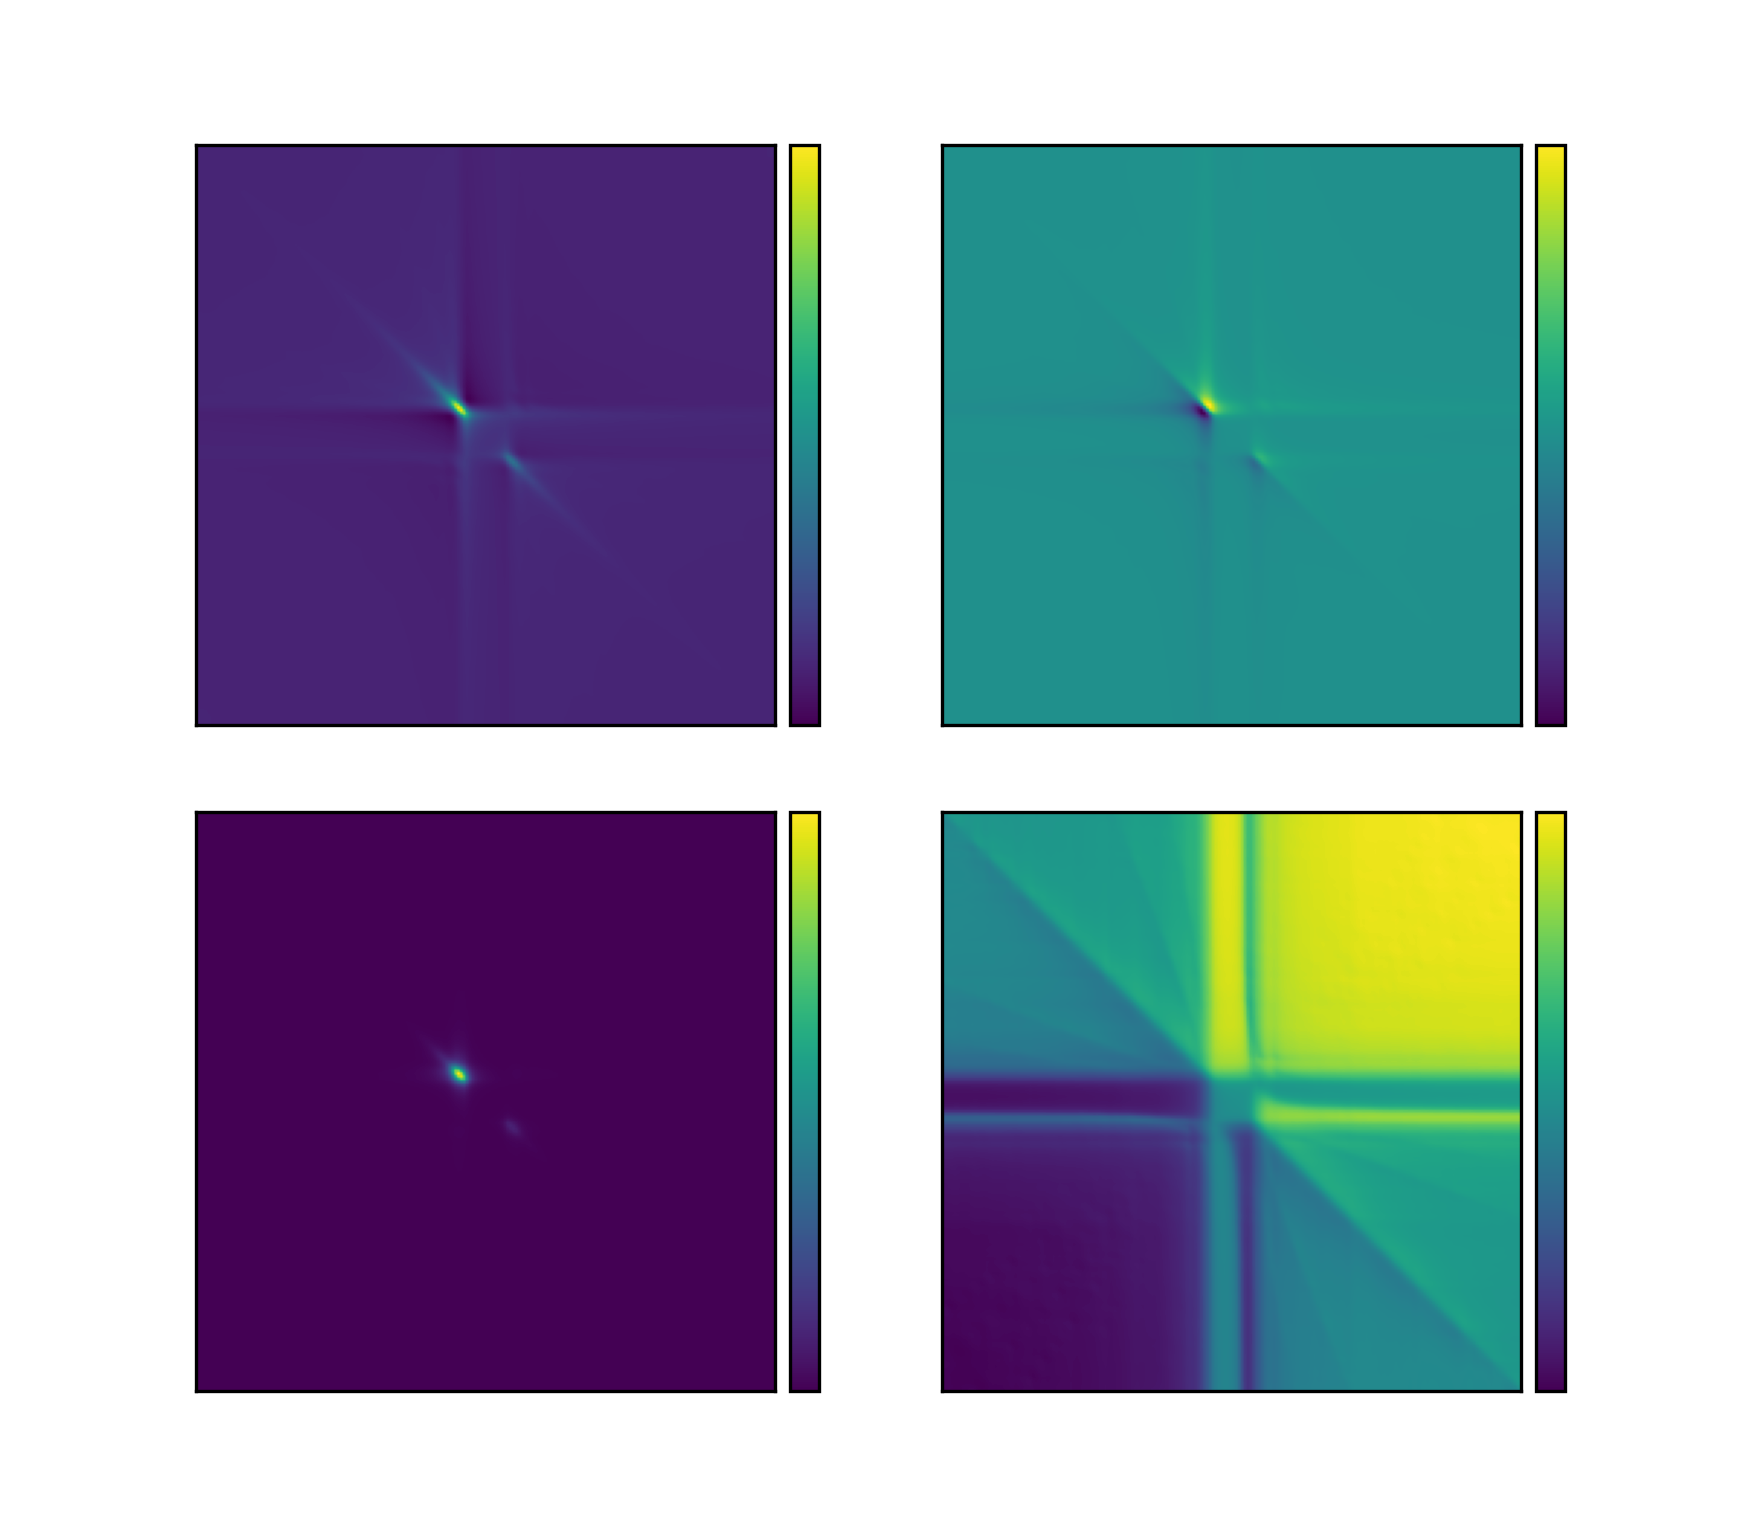

In [121]:
I_uniDir_ReImAmPh = np.array([I_uniDir.real, I_uniDir.imag, abs2(I_uniDir), phase(I_uniDir)])
fig_uniDir = slices_plots(I_uniDir_ReImAmPh, 
                      shared_title='Unidirectional ' r'$\epsilon_{yy}$' ' in cystral basis', 
                      shared_title_y_position=0.95,
                      figure_shape=[2,2], 
                      figure_size=[6,5.5],
                      titles=[r'$\mathfrak{R} \left\{I_{uniDir} (\omega_t, \omega_\tau) \right\}$', 
                              r'$\mathfrak{I} \left\{I_{uniDir} (\omega_t, \omega_\tau) \right\}$',
                              r'$             \left |I_{uniDir} (\omega_t, \omega_\tau) \right |^2$',
                              r'$     \varphi \left (I_{uniDir} (\omega_t, \omega_\tau) \right )$'],
                      horizontal_gap=0.15,
                      shared_y_label_x_position=0.04, 
                      shared_x_label_y_position=0.06)

# p = 0

## Transverse SiV

\[
\begin{pmatrix}
p \, \epsilon_{yy_0} & 0 & 0\\
0 & \epsilon_{yy_0} & 0\\
0 & 0 & p \, \epsilon_{yy_0}\\
\end{pmatrix} = 
\begin{pmatrix}
0 & 0 & 0\\
0 & \epsilon_{yy_0} & 0\\
0 & 0 & 0\\
\end{pmatrix}
\]

\begin{equation}\label{eq:71}
\epsilon_{yy}^{tr} \left( \epsilon_{yy_0}, p=0 \right) = \epsilon_{yy_0}
\end{equation}

\begin{equation}\label{eq:5}
    I_{tr}\left(\omega_t, \omega_\tau, p=0 \right) \propto \int^{\infty}_{-\infty} d \epsilon_{yy_0} \frac{1}{ \sigma \sqrt{2 \pi} } exp \left[ \frac{-\epsilon_{yy_0}^2}{2 \sigma^2} \right] \, \rho \left(\omega_t, \omega_{\tau}, \epsilon_{yy} = \epsilon_{yy_0} \right)
\end{equation}

In [122]:
@numba.jit
def tr_p0_MCint(
        omega_t=omega_t,
        omega_tau=omega_tau,
        MC_N=MC_N  # MC Steps
):

    randn_eps_yy_0 = sigma * np.random.randn(MC_N)  # normal distribution

    I_tr_p0 = 1.j * np.zeros((res, res))

    if MC_N >= res**2:

        # looping over omega mesh, equivalent to the below, tends to be faster if MC_N > res^2
        for i, om_t in enumerate(omega_t):
            for j, om_tau in enumerate(omega_tau):
                I_tr_p0[j, i] = np.mean(
                    rho(om_t,
                        om_tau,
                        eps_yy=randn_eps_yy_0))

    else:

        # looping over MC stemp, equivalent to the top, tends to be faster if MC_N < res^2
        for i in range(MC_N):
            I_tr_p0 += rho(omega_t_mesh,
                        omega_tau_mesh,
                        eps_yy=randn_eps_yy_0[i])

    return I_tr_p0

In [123]:
if MC_all:
    
    I_tr_p0 = tr_p0_MCint()
    
else:

    func = lambda eps_yy_0: Gaus(eps_yy_0) * rho(omega_t_mesh, 
                                             omega_tau_mesh, 
                                             eps_yy=eps_yy_0)

    I_tr_p0, int_err_tr_p0 = infint(func)

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/3117598322.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "tr_p0_MCint" failed type inference due to: Invalid use of type(CPUDispatcher(<function rho at 0x7fdd59023670>)) with parameters (float64, float64, eps_yy=array(float64, 1d, C))

During: resolving callee type: type(CPUDispatcher(<function rho at 0x7fdd59023670>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/3117598322.py (18)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/3117598322.py", line 18:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/3117598322.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "tr_p0_MCint" failed type inference due to: Cannot determine Numba type of <class 'numba.core.disp

# Axial SiV

\[
\begin{pmatrix}
\frac{1 + 2 p}{3} \epsilon_{yy_0} & 0 & \frac{\sqrt{2} \, \left(1 - p \right)}{3} \epsilon_{yy_0}\\
0 & p \, \epsilon_{yy_0} & 0\\
\frac{\sqrt{2} \, \left(1 - p \right)}{3} \epsilon_{yy_0} & 0 & \frac{2 + p}{3} \epsilon_{yy_0}\\
\end{pmatrix} = 
\begin{pmatrix}
\frac{1}{3} \epsilon_{yy_0} & 0 & \frac{\sqrt{2}}{3} \epsilon_{yy_0}\\
0 & 0 & 0\\
\frac{\sqrt{2}}{3} \epsilon_{yy_0} & 0 & \frac{2}{3} \epsilon_{yy_0}\\
\end{pmatrix}
\]

\begin{equation}\label{eq:74}
\epsilon_{xx}^{ax, (a)} \left( \epsilon_{yy_0} , p=0 \right) = \frac{1}{3} \epsilon_{yy_0}
\end{equation}

\begin{equation}\label{eq:75}
\epsilon_{zz}^{ax, (a)} \left( \epsilon_{yy_0} , p=0 \right) = \frac{2}{3} \epsilon_{yy_0}
\end{equation}

\begin{equation}\label{eq:76}
\epsilon_{zx}^{ax, (a)} \left( \epsilon_{yy_0} , p=0 \right) = \frac{\sqrt{2}}{3} \epsilon_{yy_0}
\end{equation}

\begin{equation}\label{eq:77}
    I_{ax, (a)}\left(\omega_t, \omega_\tau, p=0 \right) \propto \int^{\infty}_{-\infty} d \epsilon_{yy_0} \frac{1}{ \sigma \sqrt{2 \pi} } exp \left[ \frac{-\epsilon_{yy_0}^2}{2 \sigma^2} \right] \, \rho \left(\omega_t, \omega_{\tau}, \epsilon_{xx}= \frac{1}{3} \epsilon_{yy_0}, \epsilon_{zz}= \frac{2}{3} \epsilon_{yy_0}, \epsilon_{zx}= \frac{\sqrt{2}}{3} \epsilon_{yy_0} \right)
\end{equation}

In [124]:
@numba.jit
def ax_p0_MCint(
        omega_t=omega_t,
        omega_tau=omega_tau,
        MC_N=MC_N  # MC Steps
):

    randn_eps_yy_0 = sigma * np.random.randn(MC_N)  # normal distribution

    I_ax_p0 = 1.j * np.zeros((res, res))

    if MC_N >= res**2:

        # looping over omega mesh, equivalent to the below, tends to be faster if MC_N > res^2
        for i, om_t in enumerate(omega_t):
            for j, om_tau in enumerate(omega_tau):
                I_ax_p0[j, i] = np.mean(
                    rho(om_t,
                        om_tau,
                        eps_xx=randn_eps_yy_0 / 3.,
                        eps_zz=2./3. * randn_eps_yy_0,
                        eps_zx=np.sqrt(2.)/3. * randn_eps_yy_0
                       ))

    else:

        # looping over MC stemp, equivalent to the top, tends to be faster if MC_N < res^2
        for i in range(MC_N):
            I_ax_p0 += rho(omega_t_mesh,
                        omega_tau_mesh,
                        eps_xx=randn_eps_yy_0[i] / 3.,
                        eps_zz=2./3. * randn_eps_yy_0[i],
                        eps_zx=np.sqrt(2.)/3. * randn_eps_yy_0[i])

    return I_ax_p0

In [125]:
if MC_all:
    
    I_ax_p0 = ax_p0_MCint()
    
    I_uniDir_p0 = I_tr_p0 + I_ax_p0
    
    I_uniDir_p0 /= np.sqrt(np.max(abs2(I_uniDir_p0)))
    
else:

    func = lambda eps_yy_0: Gaus(eps_yy_0) * rho(omega_t_mesh, 
                                                 omega_tau_mesh, 
                                                 eps_xx=eps_yy_0 / 3.,
                                                 eps_zz=2./3. * eps_yy_0,
                                                 eps_zx=np.sqrt(2.)/3. * eps_yy_0
                                                )
    I_ax_p0, int_err_ax_p0 = infint(func)

    I_uniDir_p0 = I_tr_p0 + I_ax_p0

    I_uniDir_p0 /= np.sqrt(np.max(abs2(I_uniDir_p0)))

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/3378008085.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "ax_p0_MCint" failed type inference due to: Invalid use of type(CPUDispatcher(<function rho at 0x7fdd59023670>)) with parameters (float64, float64, eps_yy=array(float64, 1d, C))

During: resolving callee type: type(CPUDispatcher(<function rho at 0x7fdd59023670>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/3378008085.py (18)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/3378008085.py", line 18:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_1093/3378008085.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "ax_p0_MCint" failed type inference due to: Cannot determine Numba type of <class 'numba.core.disp

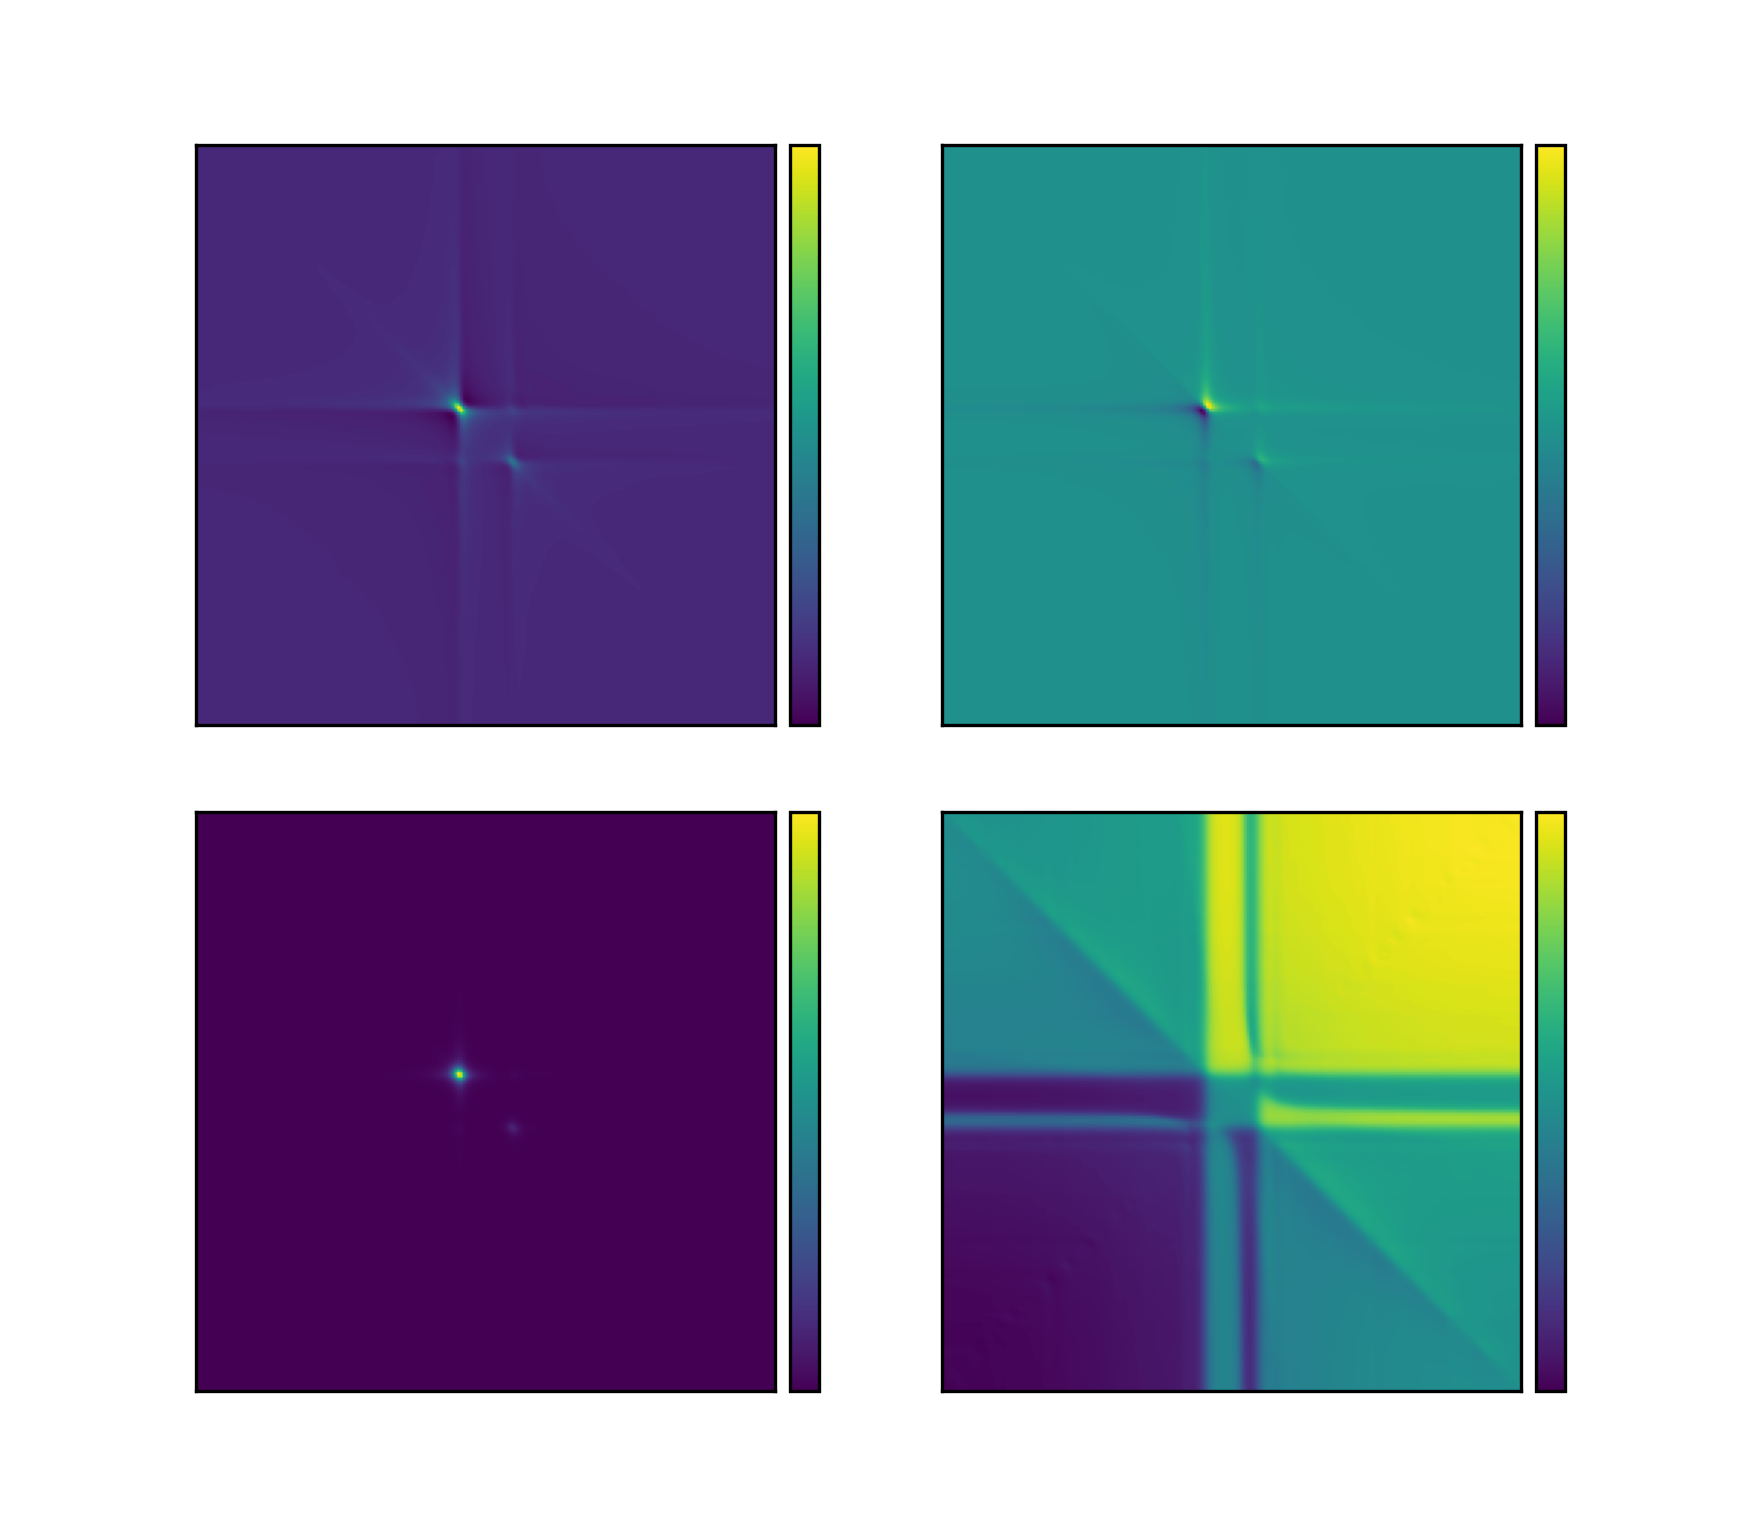

In [126]:
I_uniDir_p0_ReImAmPh = np.array([I_uniDir_p0.real, I_uniDir_p0.imag, abs2(I_uniDir_p0), phase(I_uniDir_p0)])
fig_uniDir_p0 = slices_plots(I_uniDir_p0_ReImAmPh, 
                      shared_title='Unidirectional ' r'$\epsilon_{yy}$' ' in cystral basis, ' r'$p = 0$', 
                      shared_title_y_position=0.95,
                      figure_shape=[2,2], 
                      figure_size=[6,5.5],
                      titles=[r'$\mathfrak{R} \left\{I_{uniDir_{p0}} (\omega_t, \omega_\tau) \right\}$', 
                              r'$\mathfrak{I} \left\{I_{uniDir_{p0}} (\omega_t, \omega_\tau) \right\}$',
                              r'$             \left |I_{uniDir_{p0}} (\omega_t, \omega_\tau) \right |^2$',
                              r'$     \varphi \left (I_{uniDir_{p0}} (\omega_t, \omega_\tau) \right )$'],
                      horizontal_gap=0.15,
                      shared_y_label_x_position=0.04, 
                      shared_x_label_y_position=0.06)

fig_uniDir_p0.savefig("/Users/tommychin/Documents/research/Smallwood_research/uniDir_p0.pdf", 
                 format='pdf', 
                 bbox_inches='tight')

np.save("/Users/tommychin/Documents/research/Smallwood_research/uniDir.npy", I_uniDir)